Идея:
* Попробовать строить модели с большим числом тем и включать регуляризатор отбора тем
* регуляризатор отбора тем нельзя включать сразу
* регуляризатор отбора тем нельзя включать вместе с регуляризатором декоррелирования

**Без регуляризатора**
* 100 -> 99
* **kernel size**: 24 vs 24, **purity**: .63 vs .68, **contrast** .78 vs .79, **$phi_{ij}$**: --+-+
* **closest by dist**: 
* **inter distances**: 

|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|  closest by dist test/original   	|  j12 	|j48-h76|j82-h90|j84-h92|
|   closest by dist original/test  	|   -  	|   -  	|   - 	|  -  	|
| closest by opt res test/original 	|  h8  	|  h84 	|  h94 	| h100	|
| closest by opt res original/test 	|     	|  h78 	|  h92 	| h100 	|
** best by dist test/original**
* create_model_rch_100_3_decor_ts(6 -1.5 -1.5; 0.9 -0.5 -0.5)
* 100 -> 98
* **kernel size**: 24 vs 23, **purity**: .63 vs .67, **contrast** .78 vs .82, **$phi_{ij}$**: --+-+
* **closest by dist**: 
* **inter distances**: 

|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|  closest by dist test/original   	|  j10 	|j42-h64|j81-h86|j84-h92|
|   closest by dist original/test  	|   -  	|   -  	|   - 	|  -  	|
| closest by opt res test/original 	|    	|  h70 	|  h90 	| h98	|
| closest by opt res original/test 	|     	|  h64 	|  h90 	| h100 	|
** best by opt test/original** см. пред.

** best by opt original/test** см. пред.

In [1]:
import pickle
import sys
import numpy as np
import pandas as pd
import artm
import seaborn as sns
import matplotlib.pyplot as plt
print artm.version()

from os import path, mkdir
from datetime import datetime
sys.path.insert(0, '..\\modules\\helpers')

import distances_helper as dh 
import print_helper as ph
import create_model_helper as cmh
import build_convex_hull_helper as bchh
import test_vs_original_columns_helper as tvsoch
import compare_two_models as ctm

from plot_helper import PlotMaker
from config_helper import ConfigPaths
from scipy.optimize import minimize

0.8.1


In [2]:
config = ConfigPaths('config_sample_m3.cfg')
print config.models_file_name
models_file = open(config.models_file_name, 'a')

plot_maker = PlotMaker()

batch_vectorizer = artm.BatchVectorizer(data_path=config.output_batches_path,
                                        data_format='batches')
dictionary = artm.Dictionary()
dictionary.load(dictionary_path=config.dictionary_path + '.dict')

Q:\\topic_modeling\\csi_science_collections.git\experiments\pn_model3\np_reg_19_03\models.txt


In [3]:
def save_pickle_file(dists, filename, _path=config.experiment_path):
    pickle_filename = path.join(_path, filename)
    pickle_file = open(pickle_filename, 'wb')
    pickle.dump(dists, pickle_file)
    pickle_file.close()
def load_pickle_file(filename, _path=config.experiment_path):
    pickle_filename = path.join(_path, filename)
    pickle_file = open(pickle_filename, 'rb')
    p_file = pickle.load(pickle_file)
    pickle_file.close()
    return p_file
def plot_convex_hull_topics_iterations_distribution(_phi_convex_hull):
    get_iteration_number_fn = lambda x: int(x[x.find('_', 6) + 1 : ])
    phi_convex_hull_iteration_number = [get_iteration_number_fn(col) for col in _phi_convex_hull.columns]
    phi_convex_hull_iteration_number = [(val, phi_convex_hull_iteration_number.count(val), 1.0 * phi_convex_hull_iteration_number.count(val) / len(phi_convex_hull_iteration_number)) for val in set(phi_convex_hull_iteration_number)]
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
    sns.barplot([x[0] for x in phi_convex_hull_iteration_number], [x[1] for x in phi_convex_hull_iteration_number], ax=ax1)
    ax1.set_title('Number of topics from each iteration')
    ax1.set_xlabel('n iteration')

    sns.barplot([x[0] for x in phi_convex_hull_iteration_number], [x[2] for x in phi_convex_hull_iteration_number], ax=ax2)
    ax2.set_title('Number of topics from each iteration (%)')
    ax2.set_xlabel('n iteration')
def plot_convex_hull_columns_change(iterations_info):
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
    ax1.plot([sum([val['n_topics_to_remove']for val in it['iterations_info_filter']]) for it in iterations_info], 
             color='r', label = 'total')
    ax1.set_title('Num columns to remove')
    get_topic_iteration_fn = lambda x: int(x[x.rfind('_') + 1 :])
    get_topic_filter_iteration_list_fn = lambda x, y: [get_topic_iteration_fn(topic) for topic in x].count(y)
    n_topics_removed_from_current_iteration = [sum([get_topic_filter_iteration_list_fn(val['removed_topics'], indx) for val in it['iterations_info_filter']]) for indx, it in enumerate(iterations_info)]
    ax1.plot(n_topics_removed_from_current_iteration, color='b', label='current iteration')
    ax1.set_xlabel('n iteration')
    ax1.legend()

    ax2.plot([val['phi_convex_hull_shape'][1] for val in iterations_info], color='r')
    ax2.set_title('Num columns of convex hull')
    ax2.set_xlabel('n iteration')
    ax2.legend()
def plot_opt_res_fun(iterations_filtering_info_name):
    %matplotlib inline
    iterations_filtering_info = load_pickle_file(iterations_filtering_info_name)
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
    values = [x.fun for item in iterations_filtering_info for val in item for x in val['opt_res'].values()]
    sns.distplot(values, color='r', bins=10, ax=ax1)
    values = [[x.fun for val in item for x in val['opt_res'].values()] for item in iterations_filtering_info]
    for val in values:
        sns.distplot(val, bins=10, ax=ax2)
def plot_opt_res_fun_filtering(iterations_filtering_info_name):
    iterations_info = load_pickle_file(iterations_filtering_info_name)
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
    values = [x.fun for item in iterations_info for val in item['iterations_info_filter'] for x in val['opt_res'].values()]
    sns.distplot(values, color='r', bins=10, ax=ax1)
    values = [[x.fun for val in item['iterations_info_filter'] for x in val['opt_res'].values()] for item in iterations_info]
    for val in values:
        sns.distplot(val, bins=10, ax=ax2)
def get_phi_granularity(phi):
    return np.mean([get_words_close_to_th_count(col)[0] for topic, col in phi.iteritems()])
def get_words_close_to_th_count(col, global_th=0.95):
    cur_sum, sum_count = 0, 0
    for val in col.sort_values()[::-1]:
        if cur_sum + val <= global_th:
            cur_sum += val
            sum_count += 1
        else:
            break
    return sum_count + 1, cur_sum
def get_opt_x_granularity(opt):
    return np.mean([get_opt_x_close_to_th_count(opt_res.x)[0] for topic, opt_res in opt.iteritems()])
def get_opt_x_close_to_th_count(opt_x, cut_th=None, global_th=0.95):
    cur_sum, sum_count = 0, 0
    opt_x_val = opt_x.copy()
    if cut_th != None:
        opt_x_val[opt_x_val < cut_th] = 0
    for val in sorted(opt_x_val)[::-1]:
        if val !=0 and cur_sum + val <= global_th:
            cur_sum += val
            sum_count += 1
        else:
            break
    return sum_count + 1, cur_sum
def get_and_plot_granularity(phi, opt_to_original, name):
    x_count_grans = [get_opt_x_close_to_th_count(opt_res.x)[0] for topic, opt_res in opt_to_original.iteritems()]
    x_count_grans_mean = np.mean(x_count_grans)
    x_count_grans_th = [get_opt_x_close_to_th_count(opt_res.x, cut_th=5*1e-2)[0] for topic, opt_res in opt_to_original.iteritems()]
    x_count_grans_mean_th = np.mean(x_count_grans_th)
    grans = [get_words_close_to_th_count(col)[0] for topic, col in phi.iteritems()]
    grans_mean = np.mean(grans) 
    
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=False, figsize=(15,5))
    sns.distplot(x_count_grans, color='r', bins=5, ax=ax1)
    sns.distplot(x_count_grans_th, color='b', bins=5, ax=ax1)
    for topic, opt_res in opt_to_original.iteritems():
        ax2.plot(sorted(opt_res.x)[::-1])
    sns.distplot(grans, color='r', bins=5, ax=ax3)
    title = '{} {} \nx_count_grans_mean = {}; th={}'.format(name, phi.shape, x_count_grans_mean, x_count_grans_mean_th)
    ax1.set_title(title)
    title = '{} {} \ngrans_mean = {}'.format(name, phi.shape, grans_mean)
    ax3.set_title(title)

    return x_count_grans, x_count_grans_mean, grans, grans_mean

def plot_different_distances(different_distances, title):
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=False, figsize=(15,5))
    
    if dh.kl_dist in different_distances.keys():
        vals = different_distances[dh.kl_dist].values.flatten()
        sns.distplot(vals, color='y', ax=ax1, label='kl')
    if dh.kl_sym_dist in different_distances.keys():
        vals = different_distances[dh.kl_sym_dist].values.flatten()
        sns.distplot(vals, color='m', ax=ax1, label='kl_sym')
    
    vals = different_distances[dh.jaccard_dist].values.flatten()
    sns.distplot(vals, color='r', ax=ax2, label='jaccard')
    plt.xlim(0.6, 1)
    sns.distplot(vals, color='r', ax=ax3, label='jaccard')

    vals = different_distances[dh.cos_dist].values.flatten()
    sns.distplot(vals,  color='b', ax=ax2, label='cos')
    plt.xlim(0.6, 1)
    sns.distplot(vals, color='b', ax=ax3, label='cos')

    vals = different_distances[dh.hellinger_dist].values.flatten()
    sns.distplot(vals, color='g', ax=ax2, label='hellinger')
    plt.xlim(0.6, 1)
    sns.distplot(vals, color='g', ax=ax3, label='hellinger')
    ax1.legend()
    ax2.legend()    
    if title != '':
        fig.suptitle(title, fontsize=14, fontweight='bold')
    
def get_distances(phi):
    different_distances = {}
    distances = [dh.jaccard_dist, dh.cos_dist, dh.hellinger_dist, dh.kl_dist, dh.kl_sym_dist]
    for dist_fn in distances:
        different_distances[dist_fn] = dh.calculate_distances(dist_fn, phi, phi)
    return different_distances
def save_and_plot(idx, names_list, phi_convex_hull_list, iterations_info_list, iterations_filtering_list):
    save_pickle_file(phi_convex_hull_list[idx], 'phi_convex_hull___' + names_list[idx])
    save_pickle_file(iterations_info_list[idx], 'iterations_info_list___' + names_list[idx])
    save_pickle_file(iterations_filtering_list[idx], 'iterations_filtering_list___' + names_list[idx])

    plot_convex_hull_topics_iterations_distribution(phi_convex_hull_list[idx])
    plot_convex_hull_columns_change(iterations_info_list[idx])

    distances_to_original_list = bchh.calculate_distances(DIST_FN, phi_convex_hull_list[idx], phi_original)
    opt_res_to_original_list = bchh.get_optimization_result(DIST_FN, None, phi_convex_hull_list[idx], phi_original,
                                                       distances_to_original_list[idx], n_closest_topics=N_CLOSEST_TOPICS_COUNT)
    opt_original_to_res_list = bchh.get_optimization_result(DIST_FN, None, phi_original,  phi_convex_hull_list[idx],
                                                       distances_to_original_list[idx].T, n_closest_topics=N_CLOSEST_TOPICS_COUNT)

    _,_,_,_ = get_and_plot_granularity(phi_convex_hull_list[idx], opt_res_to_original_list[idx], names_list[idx])
    _,_,_,_ = get_and_plot_granularity(phi_convex_hull_list[idx], opt_original_to_res_list[idx], names_list[idx])
    plot_dists(opt_res_to_original_list[idx], opt_original_to_res_list[idx], names_list[idx])
    
    different_distances = get_distances(phi_convex_hull_list[idx])
    different_distances_to_original = tvsoch.get_test_to_original_result_different_distances(phi_convex_hull_list[idx], phi_convex_hull_list[idx])
    tvsoch.plot_original_columns_count_different_distances(different_distances_to_original, n_original_columns_count=100)
    plot_different_distances(different_distances)
    return distances_to_original_list, opt_res_to_original_list, opt_original_to_res_list, different_distances, different_distances_to_original


Загрузим оригинальный sample датасет (от model3), до этого скопировав в папку с batches нужные pickle файлы модели.
Сначала провизуалируем по одной итерации каждой новой модели, а потом будем итерационно строить выпуклую оболочку для каждой модели по отдельности и затем сравнивать их. 

In [4]:
phi_original, theta_original = load_pickle_file('phi_model3.p', config.output_batches_path), load_pickle_file('theta_model3.p', config.output_batches_path)
phi_nwt_original = pd.DataFrame(0, index=phi_original.index, columns=[])
print phi_original.shape, theta_original.shape

(2216, 100) (100, 3446)


In [ ]:
def check_topic_ok(topic_phi, _debug=False):
    if type(topic_phi) != np.ndarray:
        topic_phi = np.array(topic_phi)
    significant_element_th_large, significant_element_th_small = 0.01, 0.005
    significant_elements_count_large, significant_elements_count_small = 5, 10
    # sum must be != 0 (after regulizators some topics may be zero)
    topic_sum_rule = np.sum(topic_phi) > 1e-1
    # topic must have at least n words with probability greater that th
    topic_significant_elements_count_large = len(np.where(topic_phi > significant_element_th_large)[0])
    topic_significant_elements_count_small = len(np.where(topic_phi > significant_element_th_small)[0])
    topic_significant_elements_large_rule = topic_significant_elements_count_large >= significant_elements_count_large
    topic_significant_elements_small_rule = topic_significant_elements_count_small >= significant_elements_count_small
    topic_docs_count_rule = None
    if _debug:
        print('topic_sum_rule = {} [{}], topic_significant_elements_large_rule = {} [{}], topic_significant_elements_small_rule = {} [{}]' \
              .format(topic_sum_rule, np.sum(topic_phi), 
                      topic_significant_elements_large_rule, topic_significant_elements_count_large, 
                      topic_significant_elements_small_rule, topic_significant_elements_count_small))
    return topic_sum_rule and topic_significant_elements_large_rule and topic_significant_elements_small_rule

def get_distances(phi, distances=[dh.jaccard_dist, dh.cos_dist, dh.hellinger_dist, dh.kl_dist, dh.kl_sym_dist]):
    different_distances = {}    
    for dist_fn in distances:
        print('Processing {}'.format(dist_fn))
        tmp = dh.calculate_distances(dist_fn, phi, phi)        
        if not np.any(tmp == np.inf) and not np.any(tmp == np.nan):
            different_distances[dist_fn] = tmp
    return different_distances
def reg_experiment(phi_original, phi_test, phi_nwt_original, phi_nwt_test):
    different_inter_distances_closest_1, different_inter_distances_closest_2 = None, None
    different_inter_distances_1, different_inter_distances_2 = None, None
    different_to_original_distances_closest_1, different_to_test_distances_closest_2 = None, None
    different_to_original_opts_1, different_to_test_opts_2, models_compare_matrix = None, None, None
    try:
        ph.print_phi_top_tokens(phi_original, phi_test, n_top_tokens=13)
            
        models_compare_matrix = ctm.print_models_comparasion(phi_original, phi_test, phi_nwt_original, phi_nwt_test)

        % matplotlib inline
        different_inter_distances_closest_1 = tvsoch.get_test_to_original_result_different_distances(phi_original, phi_original)
        tvsoch.plot_original_columns_count_different_distances(different_inter_distances_closest_1, 
                                                               n_original_columns_count=phi_original.shape[1], 
                                                               title='closest by dist inter 1')
        different_inter_distances_closest_2 = tvsoch.get_test_to_original_result_different_distances(phi_test, phi_test)
        tvsoch.plot_original_columns_count_different_distances(different_inter_distances_closest_2, 
                                                               n_original_columns_count=phi_test.shape[1],
                                                               title='closest by dist inter 2')


        different_inter_distances_1 = get_distances(phi_original)
        plot_different_distances(different_inter_distances_1, 'inter distances 1')
        different_inter_distances_2 = get_distances(phi_test)
        plot_different_distances(different_inter_distances_2, 'inter distances 2')


        different_to_original_distances_closest_1 = tvsoch.get_test_to_original_result_different_distances(phi_test, phi_original)
        tvsoch.plot_original_columns_count_different_distances(different_to_original_distances_closest_1, 
                                                               n_original_columns_count=phi_original.shape[1],
                                                               title='closest by dist test/original')
        different_to_test_distances_closest_2 = tvsoch.get_test_to_original_result_different_distances(phi_original, phi_test)
        tvsoch.plot_original_columns_count_different_distances(different_to_test_distances_closest_2, 
                                                               n_original_columns_count=phi_test.shape[1],
                                                               title='closest by dist original/test')


        different_to_original_opts_1 = tvsoch.get_test_to_original_opt_result_different_distances(phi_test, phi_original,
                                        distances=[dh.jaccard_dist, dh.cos_dist, dh.hellinger_dist])
        tvsoch.plot_original_columns_count_different_distances(different_to_original_opts_1, 
                                                               n_original_columns_count=phi_original.shape[1],
                                                               title='closest by opt test/original')
        different_to_test_opts_2 = tvsoch.get_test_to_original_opt_result_different_distances(phi_original, phi_test,
                                        distances=[dh.jaccard_dist, dh.cos_dist, dh.hellinger_dist])
        tvsoch.plot_original_columns_count_different_distances(different_to_test_opts_2, 
                                                               n_original_columns_count=phi_test.shape[1],
                                                               title='closest by opt original/test')


        print different_to_original_opts_1[dh.hellinger_dist][1][1]
        
    except Exception as inst:
        print('An error happened')
        print type(inst)     # the exception instance
        print inst.args      # arguments stored in .args
        print inst           
        ;
    return different_inter_distances_closest_1, different_inter_distances_closest_2, \
           different_inter_distances_1, different_inter_distances_2, \
           different_to_original_distances_closest_1, different_to_test_distances_closest_2, \
           different_to_original_opts_1, different_to_test_opts_2, models_compare_matrix
def print_phi_top_tokens(phi, topic_name, n_top_tokens=13):
    topic = phi.loc[:, topic_name]
    top_tokens_and_weight = ' '.join([u'{0}: {1:.3f}'.format(topic, weight) for topic, weight in topic.sort_values()[::-1][0:n_top_tokens].iteritems() if weight != 0])
    print(topic_name + '| ' + top_tokens_and_weight)

# 100 topics
## decorrelator only
* без обучения сначала

name = model_rch_100_1_iter_0, n_topics = 100, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -1.5
decorrelator_phi_regularizer, tau = 1.5
ss_phi_regularizer, tau = -1.5

('Filtered topics: ', 98, [u'topic_0', u'topic_1', u'topic_2', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_19', u'topic_20', u'topic_21', u'topic_22', u'topic_23', u'topic_24', u'topic_25', u'topic_26', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_34', u'topic_35', u'topic_36', u'topic_37', u'topic_38', u'topic_39', u'topic_40', u'topic_41', u'topic_42', u'topic_43', u'topic_44', u'topic_45', u'topic_46', u'topic_47', u'topic_48', u'topic_49', u'topic_50', u'topic_51', u'topic_52', u'topic_53', u'topic_54', u'topic_55', u'topic_56',

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00    98.00
non zero ratio                    0.96     0.98
|phi_ij == 0| / n_topics       2126.43  2164.63
|phi_ij > 0.2| / n_topics         0.23     0.54
|phi_ij > 0.1| / n_topics         0.89     1.62
|phi_ij > 0.01| / n_topics       27.16    21.35
|phi_ij > 0.05| / n_topics        2.63     4.65
|phi_ij > 0.001| / n_topics      80.26    47.01
topic_kernel_average_size        23.68    14.22
topic_kernel_average_purity       0.63     0.64
topic_kernel_average_contrast     0.78     0.80

Dist fn = <function kl_sym_dist at 0x000000000C0CF438>, Processed th = 100, original columns count = 98        Processing <function jaccard_dist at 0x000000000C0CF4A8>
Processing <function cos_dist at 0x000000000C0CF588>
Processing <function hellinger_dist at 0x000000000C0CF5F8>
Processing <function kl_dist at 0x000000000C01A6D8>
Processing <function kl_sym_dist at 0x000000000C0CF438>
Processing <function jaccard_dist at 0x000000000C0CF4A8>
Processing <function cos_dist at 0x000000000C0CF588>
Processing <function hellinger_dist at 0x000000000C0CF5F8>
Processing <function kl_dist at 0x000000000C01A6D8>
Processing <function kl_sym_dist at 0x000000000C0CF438>
Dist fn = <function cos_dist at 0x000000000C0CF588>, Processed th = 1.0, original columns count = 98           Column topic_16 not optimized
Column topic_29 not optimized
Column topic_32 not optimized
Column topic_39 not optimized
Column topic_53 not optimized
Column topic_55 not optimized
Column topic_60 not optimized
Column topic_6

C:\Users\Sheldon\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Dist fn = <function cos_dist at 0x000000000C0CF588>, Processed th = 1.0, original columns count = 98         Column topic_7 not optimized
Column topic_17 not optimized
Column topic_24 not optimized
Column topic_46 not optimized
Column topic_47 not optimized
Column topic_49 not optimized
Column topic_71 not optimized
Column topic_72 not optimized
Column topic_83 not optimized
Column topic_84 not optimized
Column topic_86 not optimized
Column topic_93 not optimized
Dist fn = <function hellinger_dist at 0x000000000C0CF5F8>, Processed th = 1.0, original columns count = 98     [(u'topic_0', u'topic_56', 0, 56, 0.34375794951242006), (u'topic_1', u'topic_55', 1, 55, 0.5581872725348852), (u'topic_2', u'topic_54', 2, 54, 0.46914815518484687), (u'topic_3', u'topic_53', 3, 53, 0.4340768429233528), (u'topic_4', u'topic_52', 4, 52, 0.51116176967262839), (u'topic_5', u'topic_51', 5, 51, 0.42714975712680053), (u'topic_6', u'topic_50', 6, 50, 0.55613823574966392), (u'topic_7', u'topic_49', 7, 49, 0.35

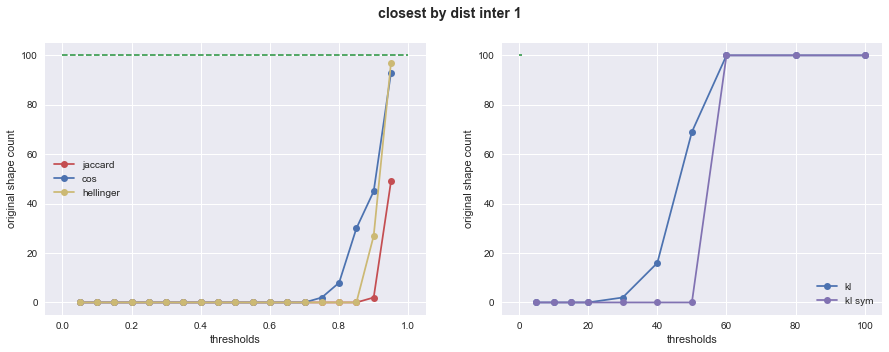

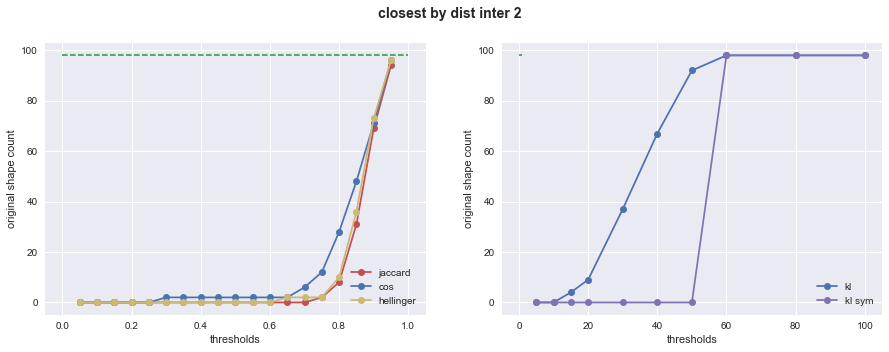

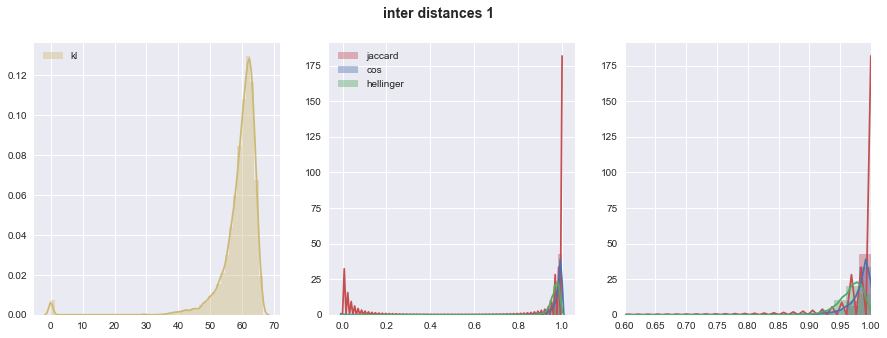

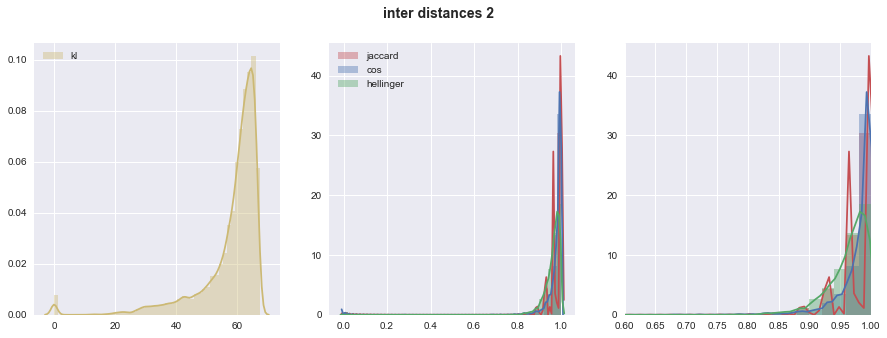

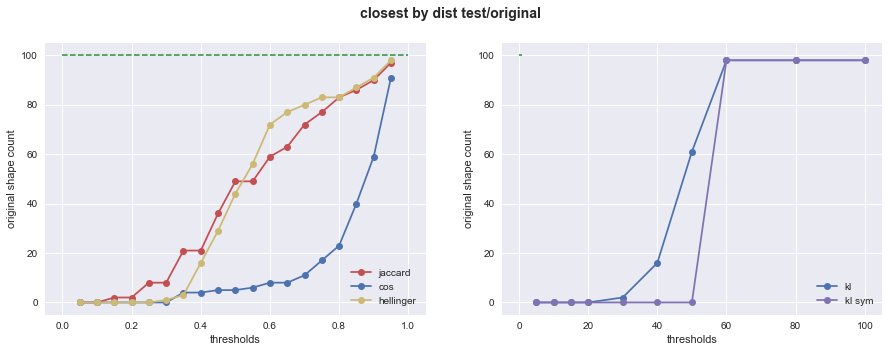

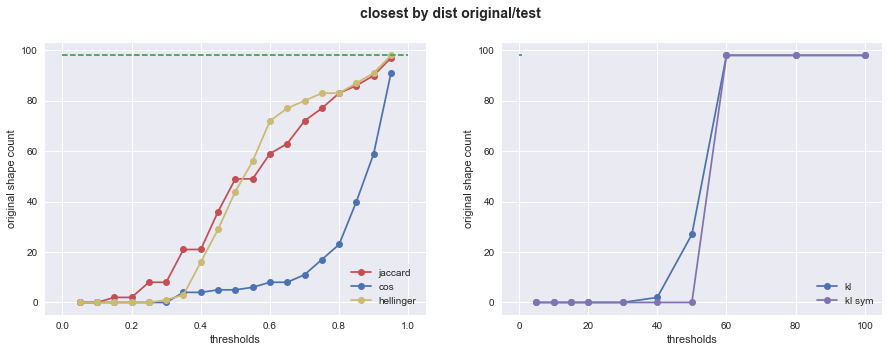

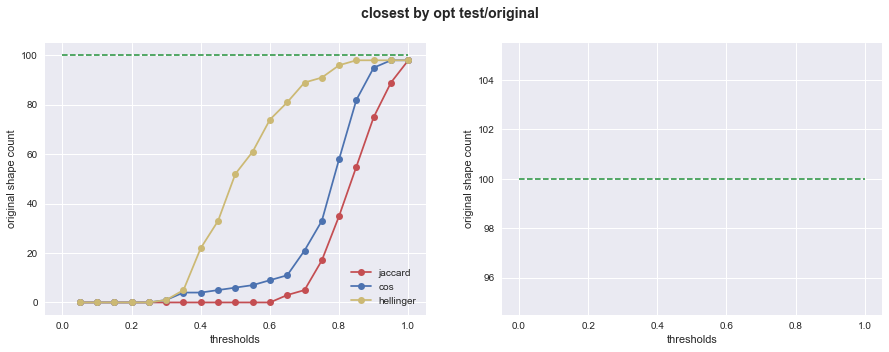

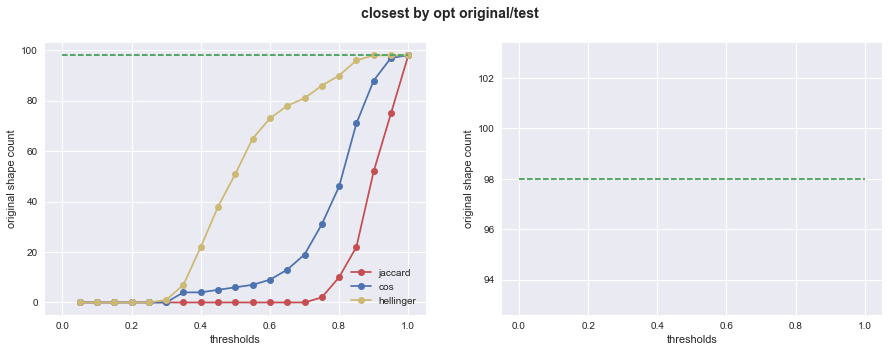

In [7]:
def create_model_rch_100_1(n_iteration, model_name='', fit=True, n_topics=100):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 1.5
    tmp_model.regularizers['ss_theta_regularizer'].tau = -1.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -1.5
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 21
names_list[idx] = u'model_rch_100_1'
models_list[idx] = create_model_rch_100_1(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* 100 -> 98, 0.98
* **kernel size**: 24 vs 14, **purity**: .63 vs .64, **contrast** .78 vs .80, **$phi_{ij}$**: похожи 
* **closest by dist**: 
* **inter distances**: 

|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|  closest by dist test/original   	|   0  	|  j20 	|j60-h70| jh84 	|
|   closest by dist original/test  	|     	|   -  	|   - 	|  -  	|
| closest by opt res test/original 	|     	|  h22 	|  h74 	|  h96 	|
| closest by opt res original/test 	|     	|   - 	|  h72 	|  h90 	|

* **Выводы**: по нахождению оригинальных хуже, чем предыдущие; по kernel (кроме size) ближе, чем предыдущие
* **TODO**: попробовать добиться того же kernel size


побольше декоррелятор + fit model сначала

name = model_rch_100_2_iter_0, n_topics = 100, n_doc_passes = 5, seed_value = 100, n_iterations = 5, top_tokens_score = 15, topic_kernel_score = 0.25

name = model_rch_100_2_iter_0, n_topics = 100, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -1.5
decorrelator_phi_regularizer, tau = 3
ss_phi_regularizer, tau = -1.5

('Filtered topics: ', 99, [u'topic_0', u'topic_1', u'topic_2', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_19', u'topic_20', u'topic_21', u'topic_22', u'topic_23', u'topic_24', u'topic_25', u'topic_26', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_34', u'topic_35', u'topic_36', u'topic_37', u'topic_38', u'topic_39', u'topic_40', u'topic_41', u'topic_42', u'topic_43', u'topi

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00    99.00
non zero ratio                    0.96     0.97
|phi_ij == 0| / n_topics       2126.43  2149.83
|phi_ij > 0.2| / n_topics         0.23     0.43
|phi_ij > 0.1| / n_topics         0.89     1.34
|phi_ij > 0.01| / n_topics       27.16    23.26
|phi_ij > 0.05| / n_topics        2.63     3.92
|phi_ij > 0.001| / n_topics      80.26    59.64
topic_kernel_average_size        23.68    22.40
topic_kernel_average_purity       0.63     0.61
topic_kernel_average_contrast     0.78     0.80

Dist fn = <function kl_sym_dist at 0x000000000C0CF438>, Processed th = 100, original columns count = 99        Processing <function jaccard_dist at 0x000000000C0CF4A8>
Processing <function cos_dist at 0x000000000C0CF588>
Processing <function hellinger_dist at 0x000000000C0CF5F8>
Processing <function kl_dist at 0x000000000C01A6D8>
Processing <function kl_sym_dist at 0x000000000C0CF438>
Processing <function jaccard_dist at 0x000000000C0CF4A8>
Processing <function cos_dist at 0x000000000C0CF588>
Processing <function hellinger_dist at 0x000000000C0CF5F8>
Processing <function kl_dist at 0x000000000C01A6D8>
Processing <function kl_sym_dist at 0x000000000C0CF438>
Dist fn = <function cos_dist at 0x000000000C0CF588>, Processed th = 1.0, original columns count = 99           Column topic_7 not optimized
Column topic_10 not optimized
Column topic_16 not optimized
Column topic_22 not optimized
Column topic_32 not optimized
Column topic_37 not optimized
Column topic_53 not optimized
Column topic_79

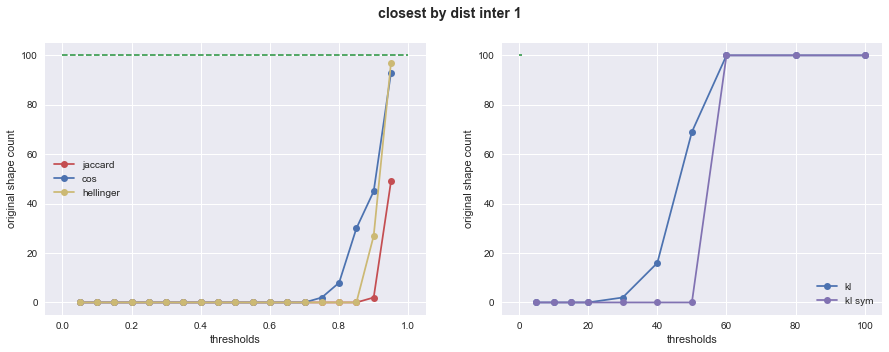

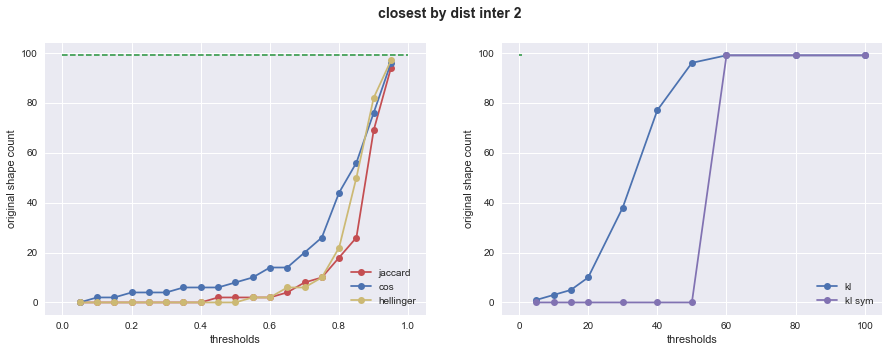

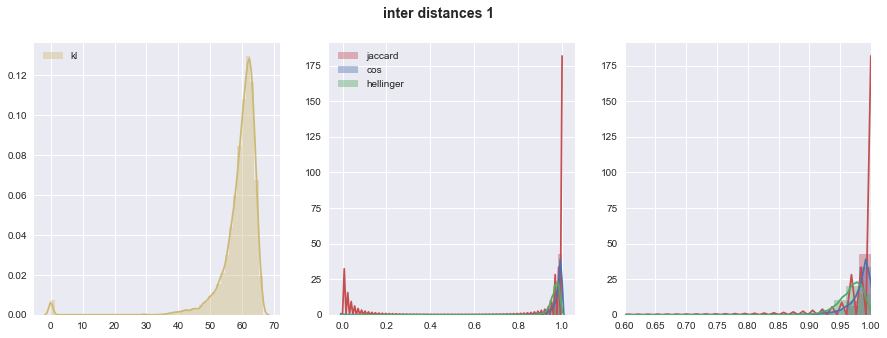

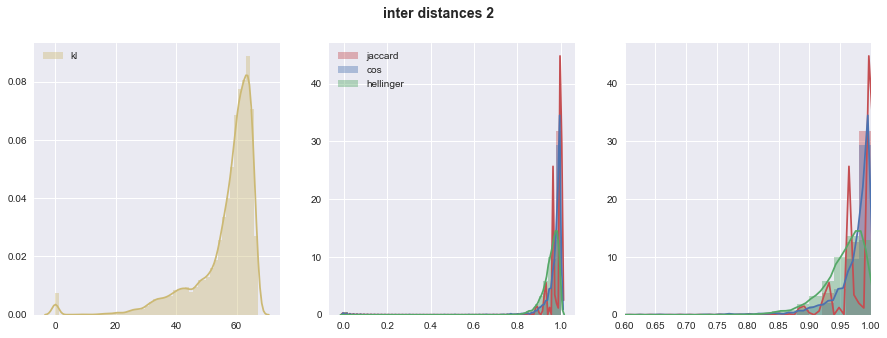

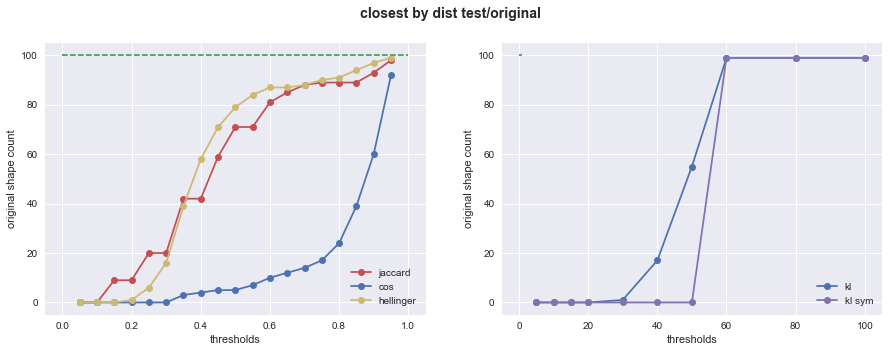

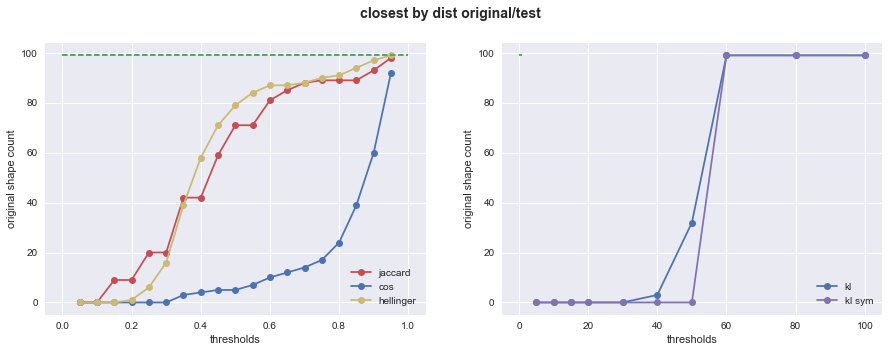

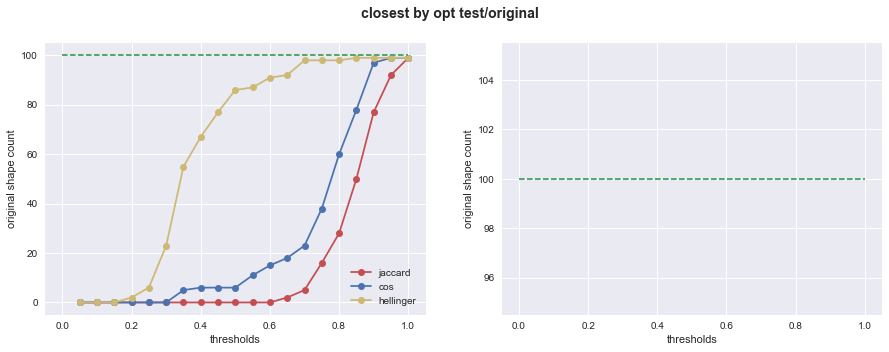

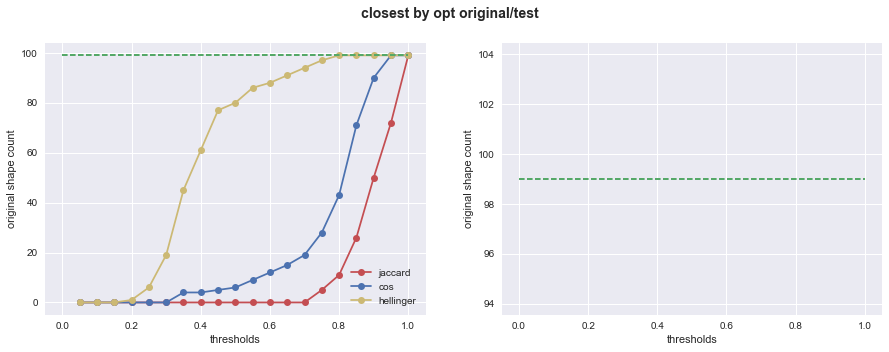

In [8]:
def create_model_rch_100_2(n_iteration, model_name='', fit=True, n_topics=100):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=5, 
                                  _model_name=model_name)
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 3
    tmp_model.regularizers['ss_theta_regularizer'].tau = -1.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -1.5
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 22
names_list[idx] = u'model_rch_100_2'
models_list[idx] = create_model_rch_100_2(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* 100 -> 99, 0.97
* **kernel size**: 24 vs 22, **purity**: .63 vs .61, **contrast** .78 vs .80, **$phi_{ij}$**:  похожи
* **closest by dist**: тестовые колонки не такие отдалённые, как original (есть дублирующие! <= 5)
* **inter distances**: более пологие распределения

|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|  closest by dist test/original   	|  j10 	|j40-h60|j80-h86| jh84 	|
|   closest by dist original/test  	|   -  	|   -  	|   - 	|  -  	|
| closest by opt res test/original 	|     	|  h64 	|  h90 	|  h98 	|
| closest by opt res original/test 	|     	|  h60 	|  h90 	| h100 	|
* **Выводы**: по kernel ближе всех, по closest by dist - примерно так же, по opt лучше 
* **TODO**:


Попробуем ещё больше декоррелятор сделать.

name = model_rch_100_3_iter_0, n_topics = 100, n_doc_passes = 5, seed_value = 100, n_iterations = 5, top_tokens_score = 15, topic_kernel_score = 0.25

name = model_rch_100_3_iter_0, n_topics = 100, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -1.5
decorrelator_phi_regularizer, tau = 6
ss_phi_regularizer, tau = -1.5

('Filtered topics: ', 99, [u'topic_0', u'topic_1', u'topic_2', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_19', u'topic_20', u'topic_21', u'topic_22', u'topic_23', u'topic_24', u'topic_25', u'topic_26', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_34', u'topic_35', u'topic_36', u'topic_37', u'topic_38', u'topic_39', u'topic_40', u'topic_41', u'topic_42', u'topic_43', u'topi

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00    99.00
non zero ratio                    0.96     0.97
|phi_ij == 0| / n_topics       2126.43  2149.87
|phi_ij > 0.2| / n_topics         0.23     0.43
|phi_ij > 0.1| / n_topics         0.89     1.34
|phi_ij > 0.01| / n_topics       27.16    23.26
|phi_ij > 0.05| / n_topics        2.63     3.93
|phi_ij > 0.001| / n_topics      80.26    59.60
topic_kernel_average_size        23.68    22.40
topic_kernel_average_purity       0.63     0.61
topic_kernel_average_contrast     0.78     0.80

Dist fn = <function kl_sym_dist at 0x000000000C0CF438>, Processed th = 100, original columns count = 99        Processing <function jaccard_dist at 0x000000000C0CF4A8>
Processing <function cos_dist at 0x000000000C0CF588>
Processing <function hellinger_dist at 0x000000000C0CF5F8>
Processing <function kl_dist at 0x000000000C01A6D8>
Processing <function kl_sym_dist at 0x000000000C0CF438>
Processing <function jaccard_dist at 0x000000000C0CF4A8>
Processing <function cos_dist at 0x000000000C0CF588>
Processing <function hellinger_dist at 0x000000000C0CF5F8>
Processing <function kl_dist at 0x000000000C01A6D8>
Processing <function kl_sym_dist at 0x000000000C0CF438>
Dist fn = <function cos_dist at 0x000000000C0CF588>, Processed th = 1.0, original columns count = 99           Column topic_14 not optimized
Column topic_32 not optimized
Column topic_34 not optimized
Column topic_37 not optimized
Column topic_42 not optimized
Column topic_51 not optimized
Column topic_83 not optimized
Column topic_8

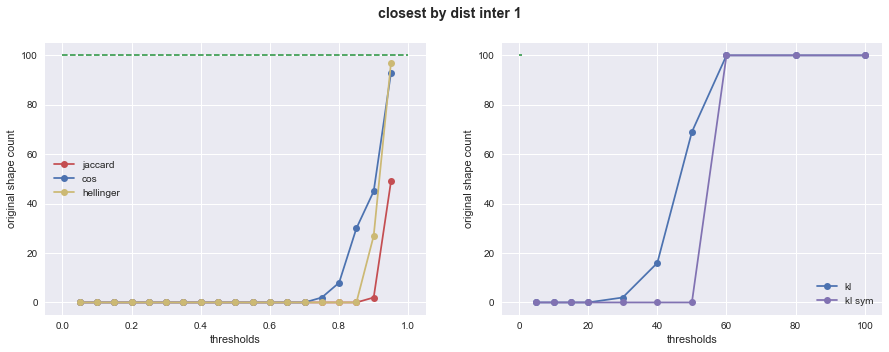

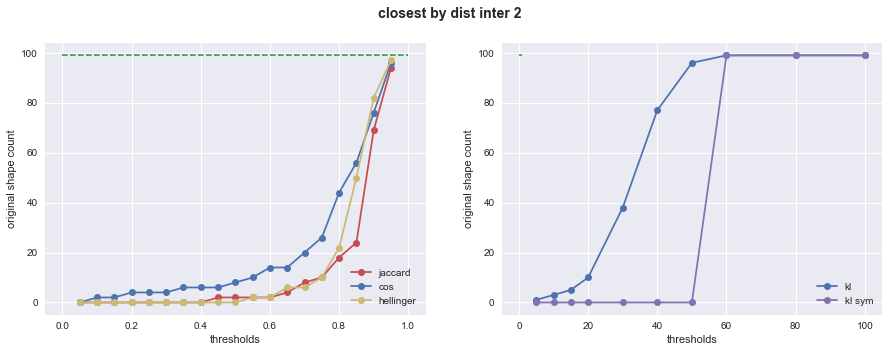

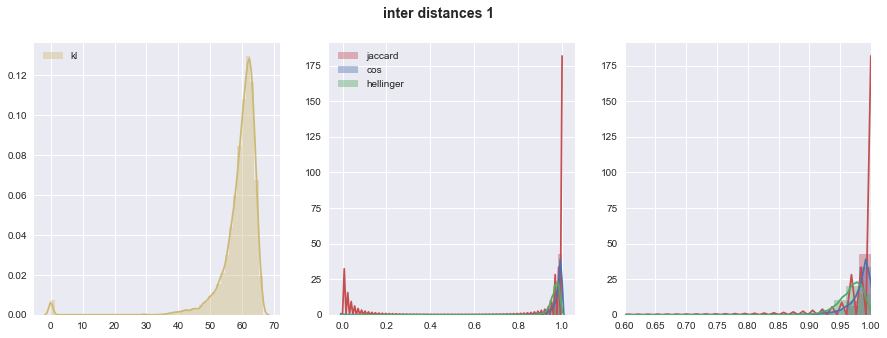

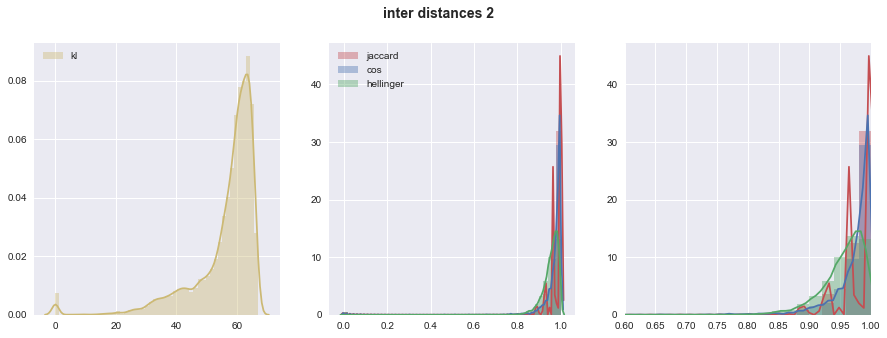

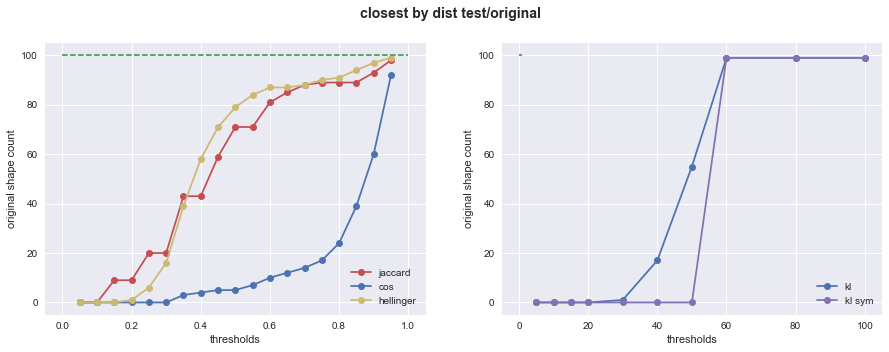

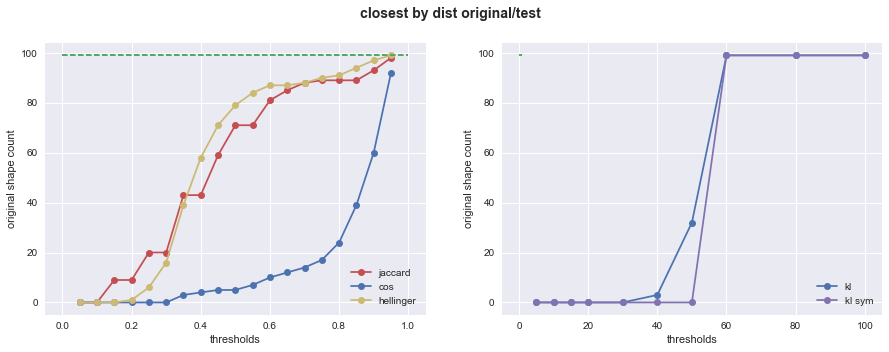

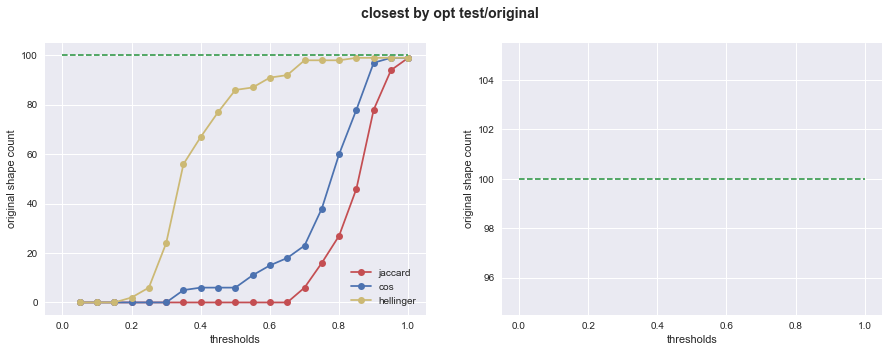

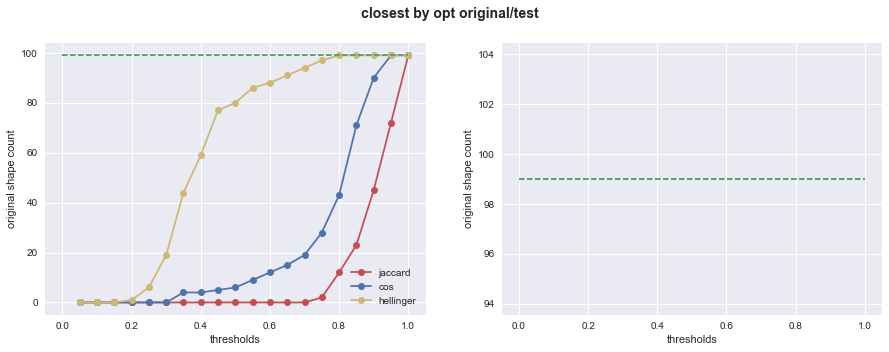

In [9]:
def create_model_rch_100_3(n_iteration, model_name='', fit=True, n_topics=100):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=5, 
                                  _model_name=model_name)
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 6
    tmp_model.regularizers['ss_theta_regularizer'].tau = -1.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -1.5
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 23
names_list[idx] = u'model_rch_100_3'
models_list[idx] = create_model_rch_100_3(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* 100 -> 99, 0.97
* **kernel size**: 24 vs 22, **purity**: .63 vs .61, **contrast** .78 vs .80, **$phi_{ij}$**: похожи 
* **closest by dist**: 
* **inter distances**: 

|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|  closest by dist test/original   	|  j10 	|j40-h60|j80-h84| jh85 	|
|   closest by dist original/test  	|   -  	|   -  	|   - 	|  -  	|
| closest by opt res test/original 	|     	|  h68 	|  h90 	|  h98 	|
| closest by opt res original/test 	|     	|  h60 	|  h90 	| h100 	|
* **Выводы**: изменение декор с 3.0 до 6.0 не сильно повлияло
* **TODO**: ещё и sparse увеличить

Попробуем убрать обучение сначала.

name = model_rch_100_4_iter_0, n_topics = 100, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -1.5
decorrelator_phi_regularizer, tau = 6
ss_phi_regularizer, tau = -1.5

('Filtered topics: ', 98, [u'topic_0', u'topic_1', u'topic_2', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_19', u'topic_20', u'topic_21', u'topic_22', u'topic_23', u'topic_24', u'topic_25', u'topic_26', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_34', u'topic_35', u'topic_36', u'topic_37', u'topic_38', u'topic_39', u'topic_40', u'topic_41', u'topic_42', u'topic_43', u'topic_44', u'topic_45', u'topic_46', u'topic_47', u'topic_48', u'topic_49', u'topic_50', u'topic_51', u'topic_52', u'topic_53', u'topic_54', u'topic_55', u'topic_56', u

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00    98.00
non zero ratio                    0.96     0.98
|phi_ij == 0| / n_topics       2126.43  2164.68
|phi_ij > 0.2| / n_topics         0.23     0.54
|phi_ij > 0.1| / n_topics         0.89     1.62
|phi_ij > 0.01| / n_topics       27.16    21.38
|phi_ij > 0.05| / n_topics        2.63     4.62
|phi_ij > 0.001| / n_topics      80.26    46.93
topic_kernel_average_size        23.68    14.22
topic_kernel_average_purity       0.63     0.64
topic_kernel_average_contrast     0.78     0.80

Dist fn = <function kl_sym_dist at 0x000000000C0CF438>, Processed th = 100, original columns count = 98        Processing <function jaccard_dist at 0x000000000C0CF4A8>
Processing <function cos_dist at 0x000000000C0CF588>
Processing <function hellinger_dist at 0x000000000C0CF5F8>
Processing <function kl_dist at 0x000000000C01A6D8>
Processing <function kl_sym_dist at 0x000000000C0CF438>
Processing <function jaccard_dist at 0x000000000C0CF4A8>
Processing <function cos_dist at 0x000000000C0CF588>
Processing <function hellinger_dist at 0x000000000C0CF5F8>
Processing <function kl_dist at 0x000000000C01A6D8>
Processing <function kl_sym_dist at 0x000000000C0CF438>
Dist fn = <function cos_dist at 0x000000000C0CF588>, Processed th = 1.0, original columns count = 98           Column topic_16 not optimized
Column topic_28 not optimized
Column topic_37 not optimized
Column topic_39 not optimized
Column topic_40 not optimized
Column topic_43 not optimized
Column topic_55 not optimized
Column topic_8

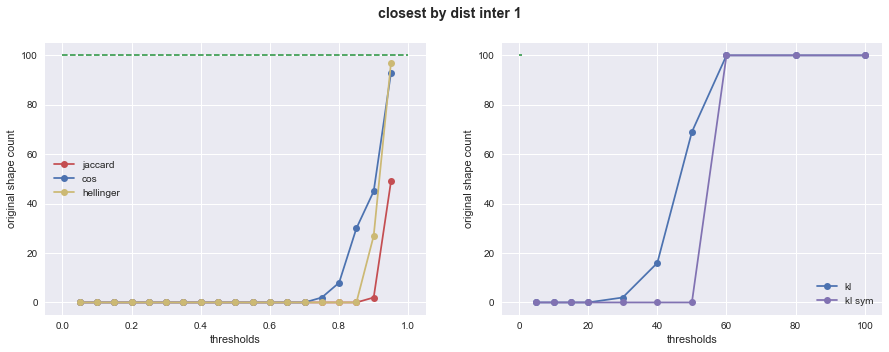

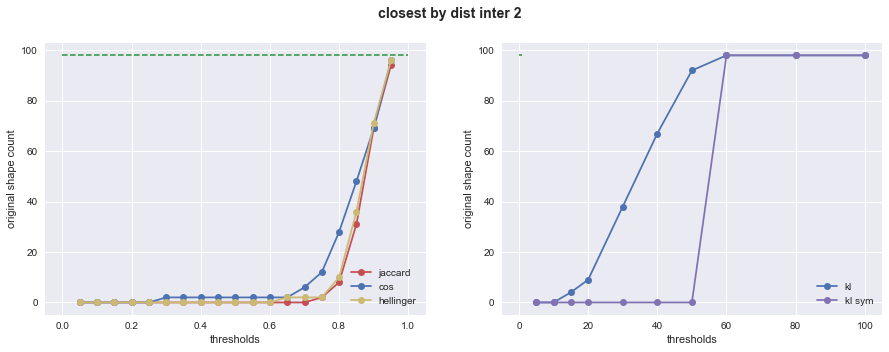

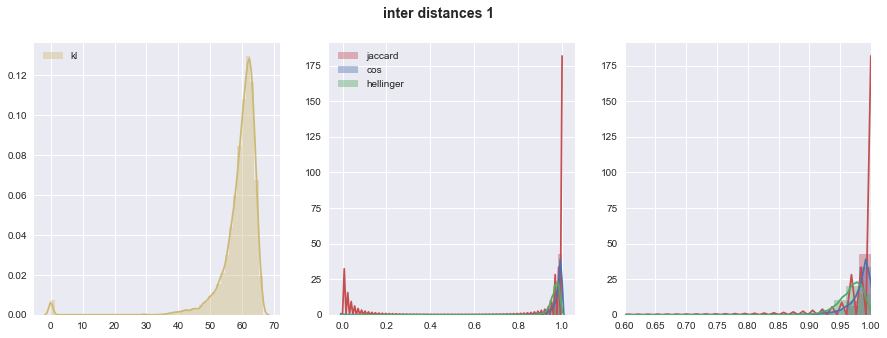

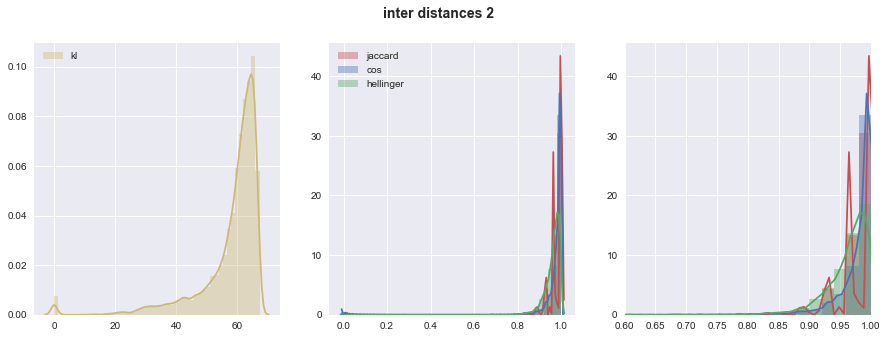

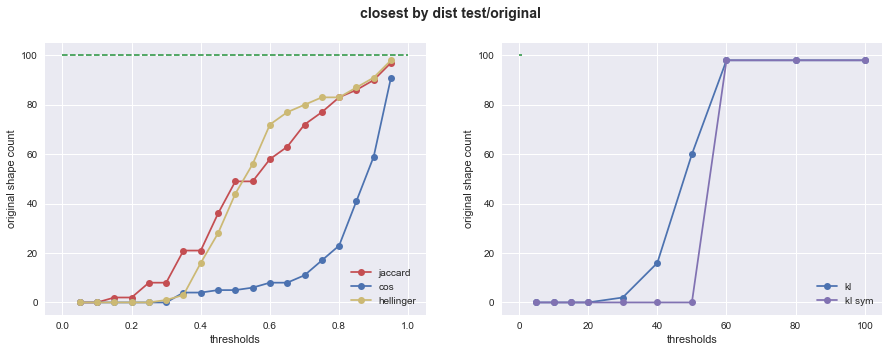

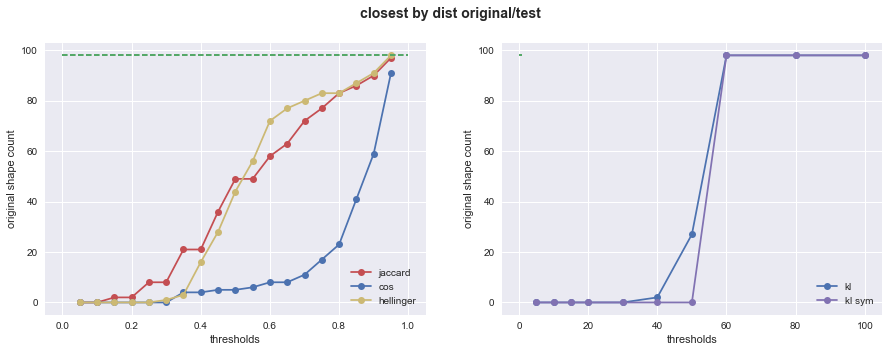

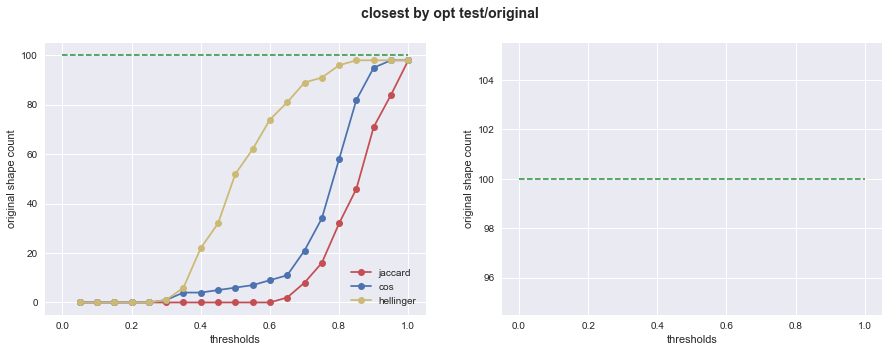

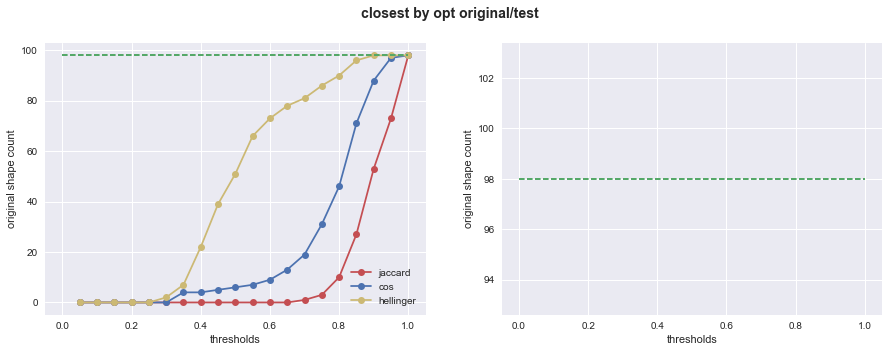

In [10]:
def create_model_rch_100_4(n_iteration, model_name='', fit=True, n_topics=100):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 6
    tmp_model.regularizers['ss_theta_regularizer'].tau = -1.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -1.5
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 24
names_list[idx] = u'model_rch_100_4'
models_list[idx] = create_model_rch_100_4(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* 100 -> 98, 0.98
* **kernel size**: 24 vs 14, **purity**: .63 vs .64, **contrast** .78 vs .80, **$phi_{ij}$**: похожи
* **closest by dist**: без обучения вначсале порог несного сместился правее, темы более различные
* **inter distances**: 

|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|  closest by dist test/original   	|  j10 	|j20-h18|j60-h72| jh82 	|
|   closest by dist original/test  	|   -  	|   -  	|   - 	|  -  	|
| closest by opt res test/original 	|     	|  h22 	|  h74 	|  h96 	|
| closest by opt res original/test 	|     	|  h22 	|  h72 	| h90 	|
* **Выводы**: если убрать начальное обучение без регуляризаторов, то kernel size становится меньше, тестовые темы более различны (?),  closest by dist  хуже
* **TODO**:

## topic selection only
Без обучения в начале, коэф маленький (0.1)

name = model_rch_100_1_ts_iter_0, n_topics = 100, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -1.5
ss_phi_regularizer, tau = -1.5
topic_selection_theta_regularizer, tau = 0.1

('Filtered topics: ', 94, [u'topic_0', u'topic_1', u'topic_2', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_19', u'topic_20', u'topic_21', u'topic_22', u'topic_23', u'topic_24', u'topic_25', u'topic_26', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_34', u'topic_35', u'topic_36', u'topic_37', u'topic_38', u'topic_39', u'topic_41', u'topic_42', u'topic_43', u'topic_44', u'topic_45', u'topic_46', u'topic_47', u'topic_48', u'topic_49', u'topic_50', u'topic_51', u'topic_52', u'topic_53', u'topic_54', u'topic_55', u'topic_56', u'to

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00    94.00
non zero ratio                    0.96     0.98
|phi_ij == 0| / n_topics       2126.43  2160.99
|phi_ij > 0.2| / n_topics         0.23     0.50
|phi_ij > 0.1| / n_topics         0.89     1.66
|phi_ij > 0.01| / n_topics       27.16    20.76
|phi_ij > 0.05| / n_topics        2.63     4.56
|phi_ij > 0.001| / n_topics      80.26    49.61
topic_kernel_average_size        23.68    15.12
topic_kernel_average_purity       0.63     0.61
topic_kernel_average_contrast     0.78     0.78

Dist fn = <function kl_sym_dist at 0x000000000C0CF438>, Processed th = 100, original columns count = 94        Processing <function jaccard_dist at 0x000000000C0CF4A8>
Processing <function cos_dist at 0x000000000C0CF588>
Processing <function hellinger_dist at 0x000000000C0CF5F8>
Processing <function kl_dist at 0x000000000C01A6D8>
Processing <function kl_sym_dist at 0x000000000C0CF438>
Processing <function jaccard_dist at 0x000000000C0CF4A8>
Processing <function cos_dist at 0x000000000C0CF588>
Processing <function hellinger_dist at 0x000000000C0CF5F8>
Processing <function kl_dist at 0x000000000C01A6D8>
Processing <function kl_sym_dist at 0x000000000C0CF438>
Dist fn = <function cos_dist at 0x000000000C0CF588>, Processed th = 1.0, original columns count = 94           Column topic_7 not optimized
Column topic_34 not optimized
Column topic_35 not optimized
Column topic_58 not optimized
Column topic_60 not optimized
Column topic_64 not optimized
Column topic_71 not optimized
Column topic_76

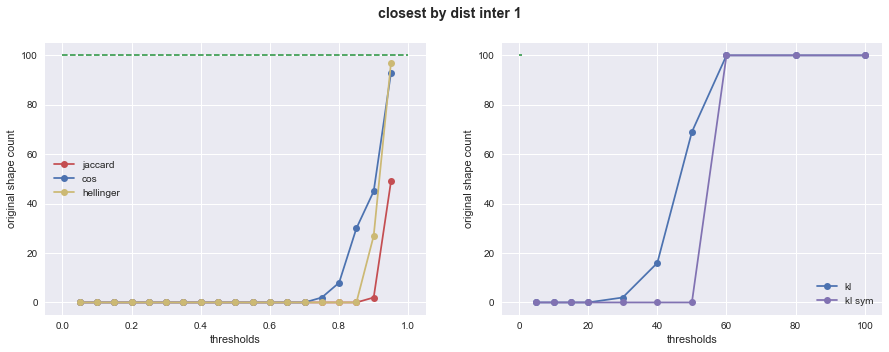

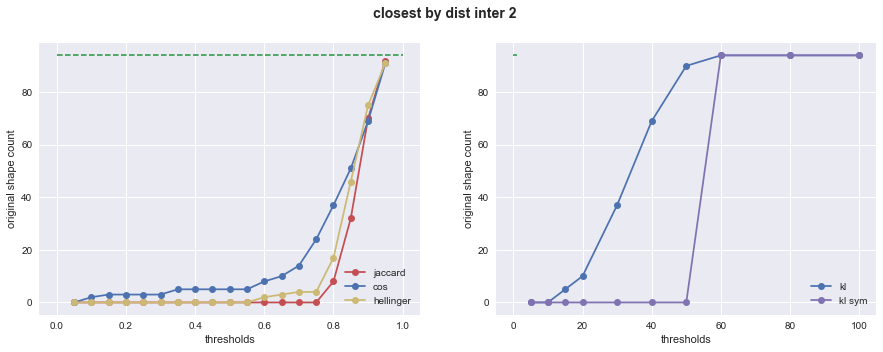

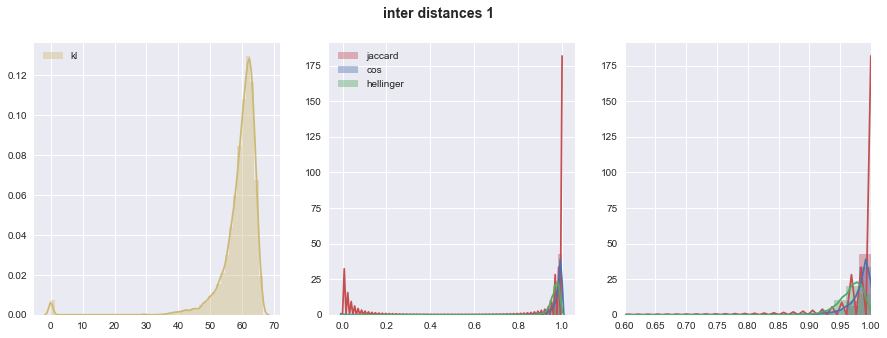

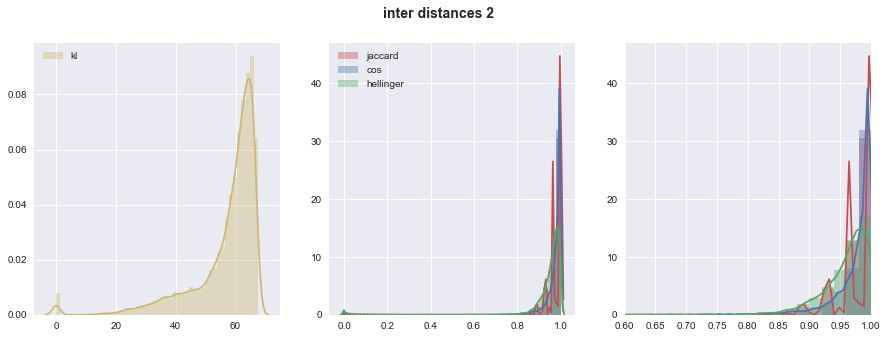

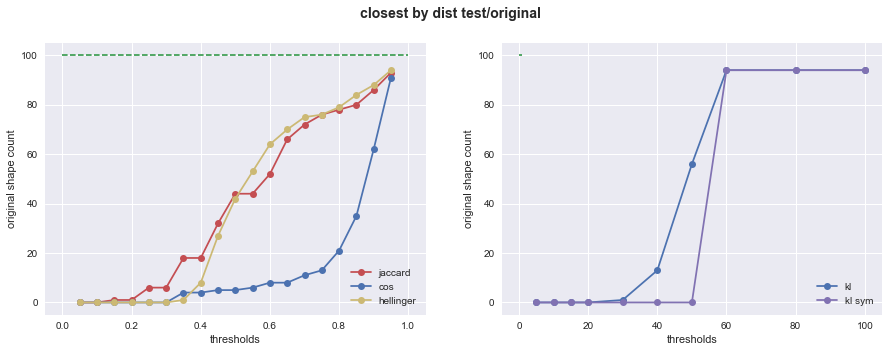

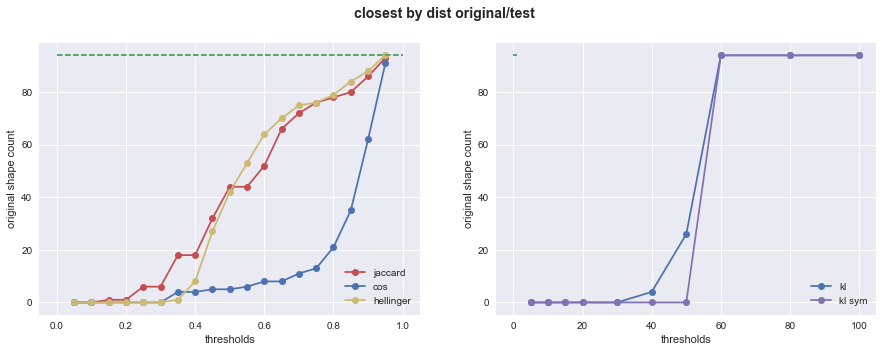

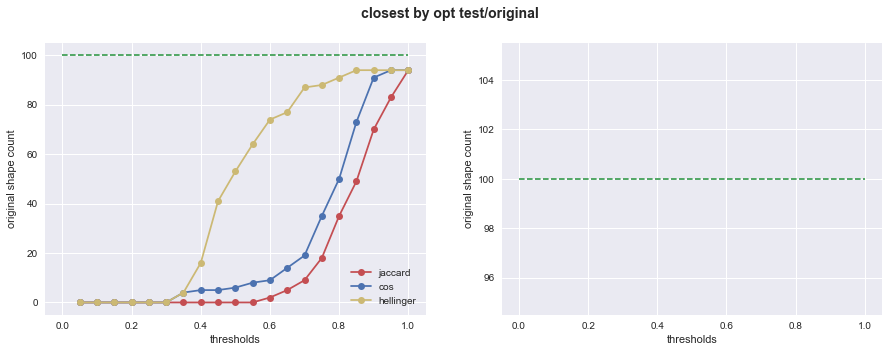

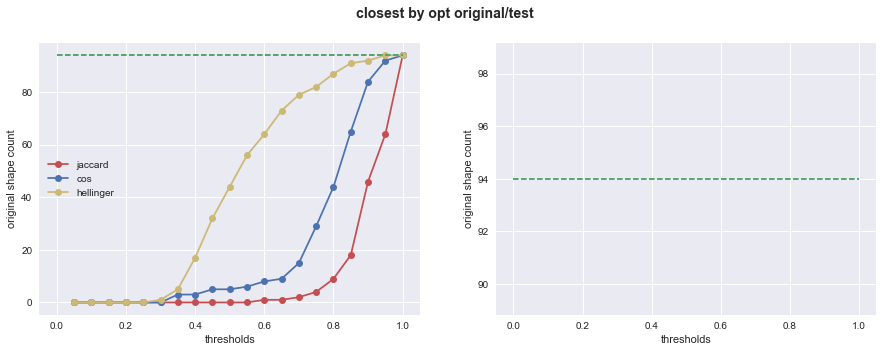

In [12]:
def create_model_rch_100_1_ts(n_iteration, model_name='', fit=True, n_topics=100):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model.regularizers.add(artm.TopicSelectionThetaRegularizer(name='topic_selection_theta_regularizer'))    
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['topic_selection_theta_regularizer'].tau = 0.1
    tmp_model.regularizers['ss_theta_regularizer'].tau = -1.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -1.5
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 31
names_list[idx] = u'model_rch_100_1_ts'
models_list[idx] = create_model_rch_100_1_ts(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* 100 -> 94, 0.98
* **kernel size**: 24 vs 15, **purity**: .63 vs .61, **contrast** .78 vs .78, **$phi_{ij}$**: --+--
* **closest by dist**: 
* **inter distances**: 

|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|  closest by dist test/original   	|  j2 	|j20-h10|j50-h64| jh80 	|
|   closest by dist original/test  	|   -  	|   -  	|   - 	|  -  	|
| closest by opt res test/original 	|     	|  h16 	|  h74 	|  h90 	|
| closest by opt res original/test 	|     	|  h18 	|  h62 	| h90 	|
* **Выводы**: не очень
* **TODO**:

Увеличим коэф (с 0 0.1 до 0.5) + начальное обучение без регуляризаторов.

name = model_rch_100_2_ts_iter_0, n_topics = 100, n_doc_passes = 5, seed_value = 100, n_iterations = 5, top_tokens_score = 15, topic_kernel_score = 0.25

name = model_rch_100_2_ts_iter_0, n_topics = 100, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -1.5
ss_phi_regularizer, tau = -1.5
topic_selection_theta_regularizer, tau = 0.5

('Filtered topics: ', 96, [u'topic_0', u'topic_1', u'topic_2', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_20', u'topic_21', u'topic_22', u'topic_23', u'topic_24', u'topic_25', u'topic_26', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_34', u'topic_35', u'topic_36', u'topic_37', u'topic_38', u'topic_40', u'topic_41', u'topic_42', u'topic_43', u'topic_44', u'topi

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00    96.00
non zero ratio                    0.96     0.96
|phi_ij == 0| / n_topics       2126.43  2131.12
|phi_ij > 0.2| / n_topics         0.23     0.36
|phi_ij > 0.1| / n_topics         0.89     1.19
|phi_ij > 0.01| / n_topics       27.16    23.92
|phi_ij > 0.05| / n_topics        2.63     3.51
|phi_ij > 0.001| / n_topics      80.26    72.49
topic_kernel_average_size        23.68    22.81
topic_kernel_average_purity       0.63     0.56
topic_kernel_average_contrast     0.78     0.80

Dist fn = <function kl_sym_dist at 0x000000000C0CF438>, Processed th = 100, original columns count = 96        Processing <function jaccard_dist at 0x000000000C0CF4A8>
Processing <function cos_dist at 0x000000000C0CF588>
Processing <function hellinger_dist at 0x000000000C0CF5F8>
Processing <function kl_dist at 0x000000000C01A6D8>
Processing <function kl_sym_dist at 0x000000000C0CF438>
Processing <function jaccard_dist at 0x000000000C0CF4A8>
Processing <function cos_dist at 0x000000000C0CF588>
Processing <function hellinger_dist at 0x000000000C0CF5F8>
Processing <function kl_dist at 0x000000000C01A6D8>
Processing <function kl_sym_dist at 0x000000000C0CF438>
Dist fn = <function cos_dist at 0x000000000C0CF588>, Processed th = 1.0, original columns count = 96           Column topic_7 not optimized
Column topic_18 not optimized
Column topic_23 not optimized
Column topic_27 not optimized
Column topic_28 not optimized
Column topic_32 not optimized
Column topic_34 not optimized
Column topic_35

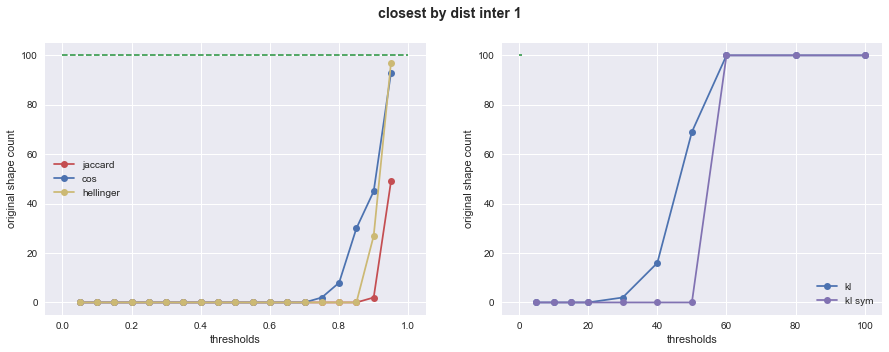

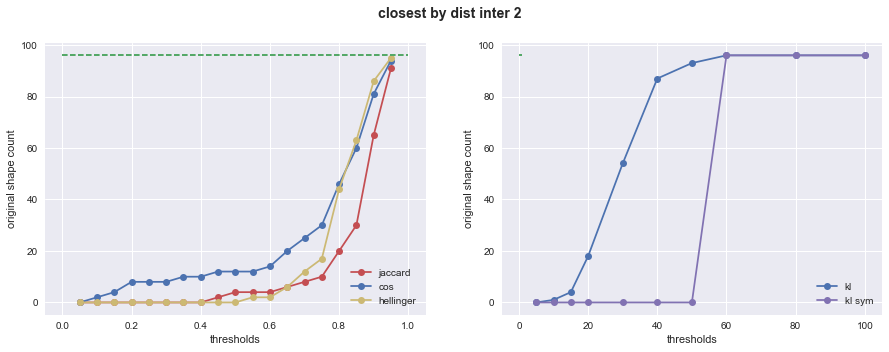

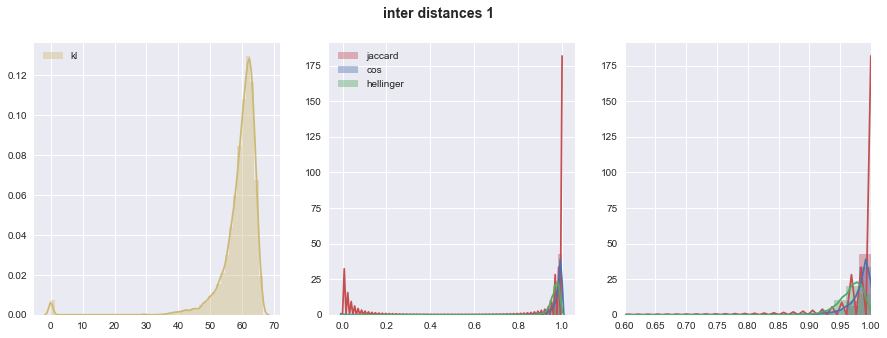

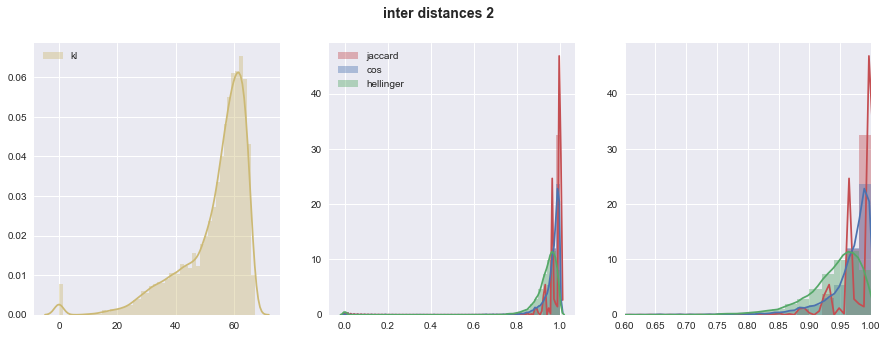

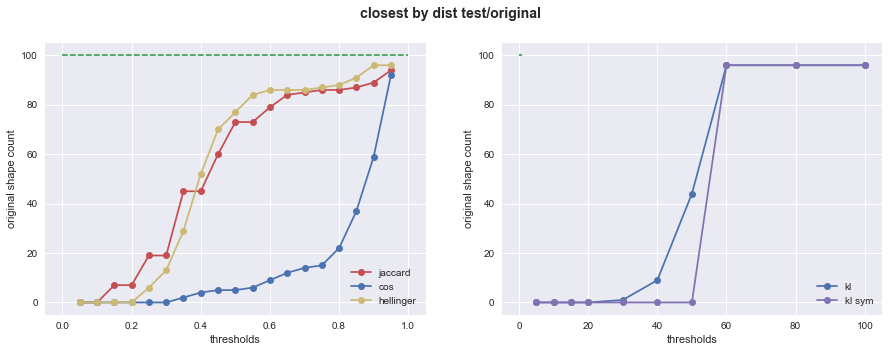

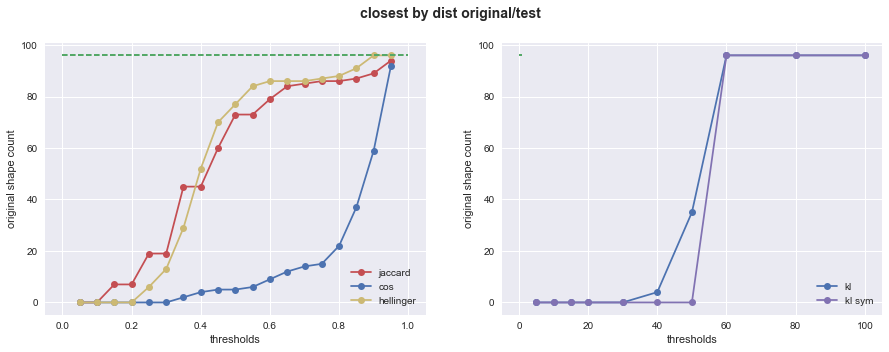

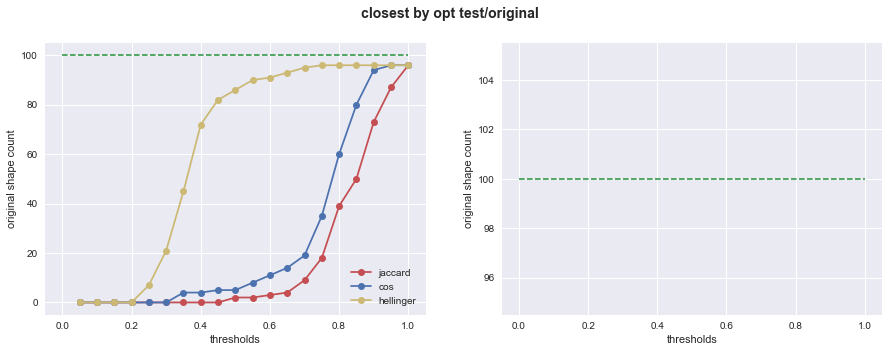

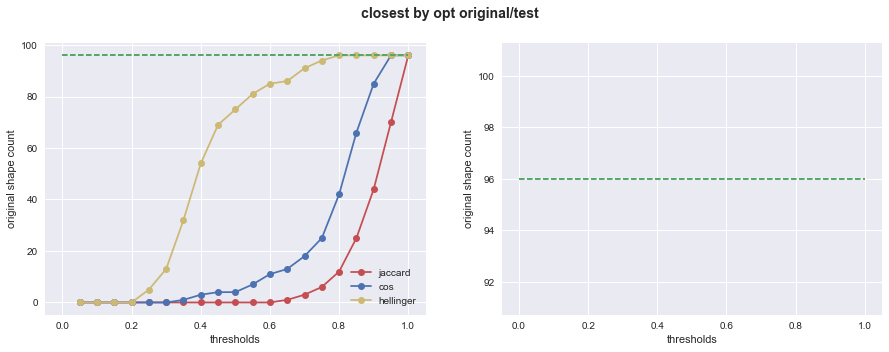

In [13]:
def create_model_rch_100_2_ts(n_iteration, model_name='', fit=True, n_topics=100):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=5, 
                                  _model_name=model_name)
    tmp_model.regularizers.add(artm.TopicSelectionThetaRegularizer(name='topic_selection_theta_regularizer'))    
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['topic_selection_theta_regularizer'].tau = 0.5
    tmp_model.regularizers['ss_theta_regularizer'].tau = -1.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -1.5
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 32
names_list[idx] = u'model_rch_100_2_ts'
models_list[idx] = create_model_rch_100_2_ts(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* 100 -> 96, 0.96
* **kernel size**: 24 vs 23, **purity**: .63 vs .56, **contrast** .78 vs .80, **$phi_{ij}$**: +++++ похожи-похожи
* **closest by dist**: 
* **inter distances**: 

|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|  closest by dist test/original   	|  j8 	|j45-h52|j80-h88| jh89 	|
|   closest by dist original/test  	|   -  	|   -  	|   - 	|  -  	|
| closest by opt res test/original 	|     	|  h72 	|  h90 	|  h98 	|
| closest by opt res original/test 	|     	|  h56 	|  h84 	| h100 	|
* **Выводы**: слабо, при 0.4 можно и 60 колонок набирать
* **TODO**: почему отличаются?

Увеличить спарсе коэффициенты (от -1.5 до -2)

name = model_rch_100_3_ts_iter_0, n_topics = 100, n_doc_passes = 5, seed_value = 100, n_iterations = 5, top_tokens_score = 15, topic_kernel_score = 0.25

name = model_rch_100_3_ts_iter_0, n_topics = 100, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -2
ss_phi_regularizer, tau = -2
topic_selection_theta_regularizer, tau = 0.5

('Filtered topics: ', 94, [u'topic_0', u'topic_1', u'topic_2', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_21', u'topic_22', u'topic_23', u'topic_24', u'topic_25', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_34', u'topic_35', u'topic_36', u'topic_37', u'topic_38', u'topic_40', u'topic_41', u'topic_42', u'topic_43', u'topic_44', u'topic_45', u'topic_46', u'topic_47

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00    94.00
non zero ratio                    0.96     0.96
|phi_ij == 0| / n_topics       2126.43  2131.49
|phi_ij > 0.2| / n_topics         0.23     0.35
|phi_ij > 0.1| / n_topics         0.89     1.22
|phi_ij > 0.01| / n_topics       27.16    24.17
|phi_ij > 0.05| / n_topics        2.63     3.32
|phi_ij > 0.001| / n_topics      80.26    72.77
topic_kernel_average_size        23.68    22.43
topic_kernel_average_purity       0.63     0.55
topic_kernel_average_contrast     0.78     0.81

Dist fn = <function kl_sym_dist at 0x000000000C0CF438>, Processed th = 100, original columns count = 94        Processing <function jaccard_dist at 0x000000000C0CF4A8>
Processing <function cos_dist at 0x000000000C0CF588>
Processing <function hellinger_dist at 0x000000000C0CF5F8>
Processing <function kl_dist at 0x000000000C01A6D8>
Processing <function kl_sym_dist at 0x000000000C0CF438>
Processing <function jaccard_dist at 0x000000000C0CF4A8>
Processing <function cos_dist at 0x000000000C0CF588>
Processing <function hellinger_dist at 0x000000000C0CF5F8>
Processing <function kl_dist at 0x000000000C01A6D8>
Processing <function kl_sym_dist at 0x000000000C0CF438>
Dist fn = <function cos_dist at 0x000000000C0CF588>, Processed th = 1.0, original columns count = 94           Column topic_4 not optimized
Column topic_15 not optimized
Column topic_16 not optimized
Column topic_24 not optimized
Column topic_32 not optimized
Column topic_33 not optimized
Column topic_40 not optimized
Column topic_41

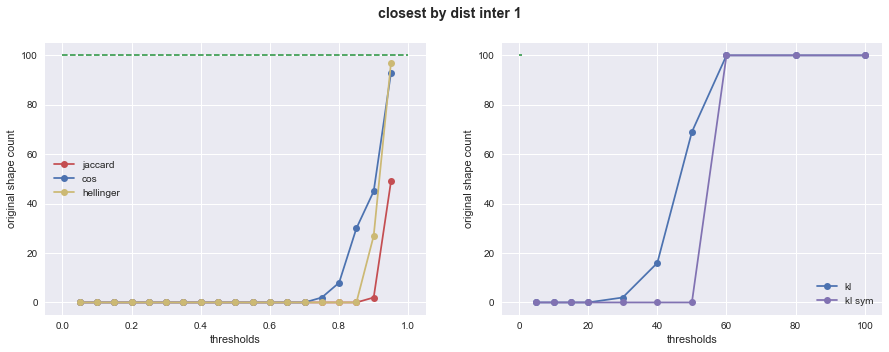

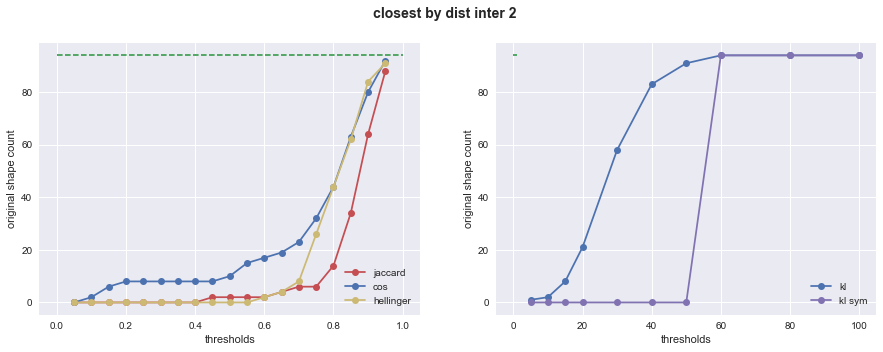

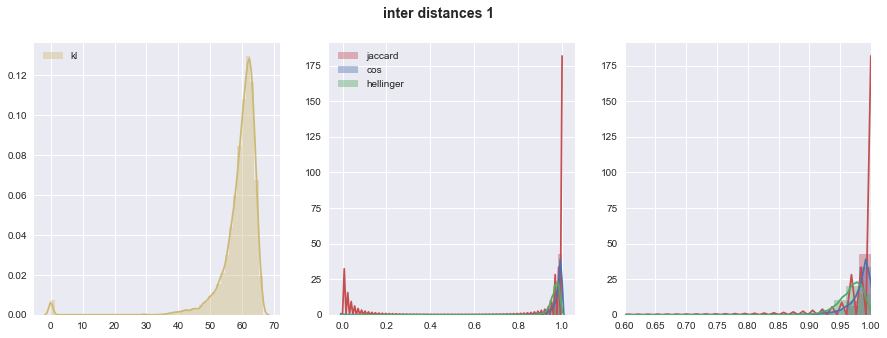

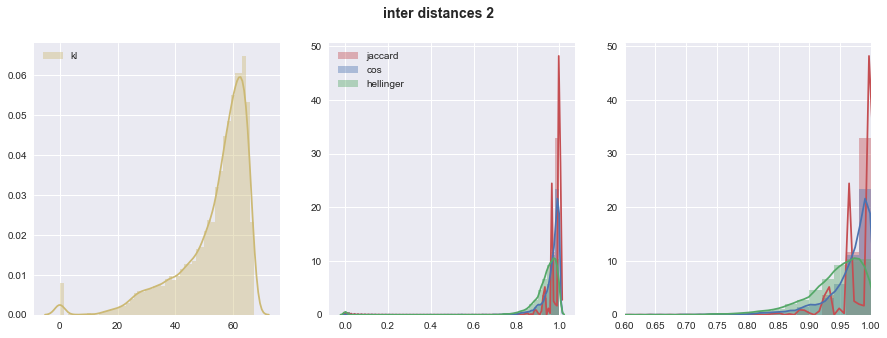

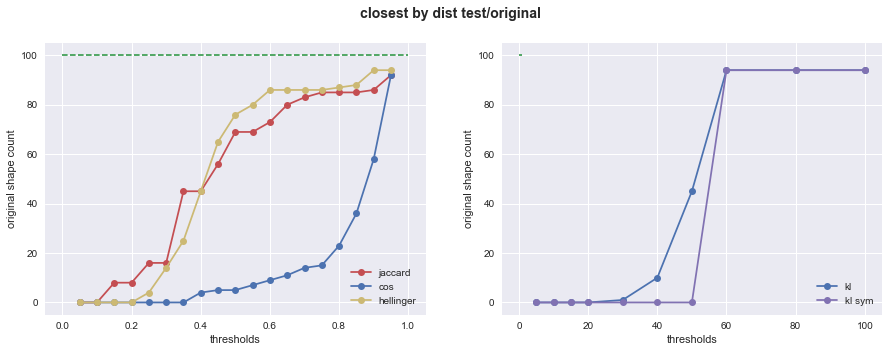

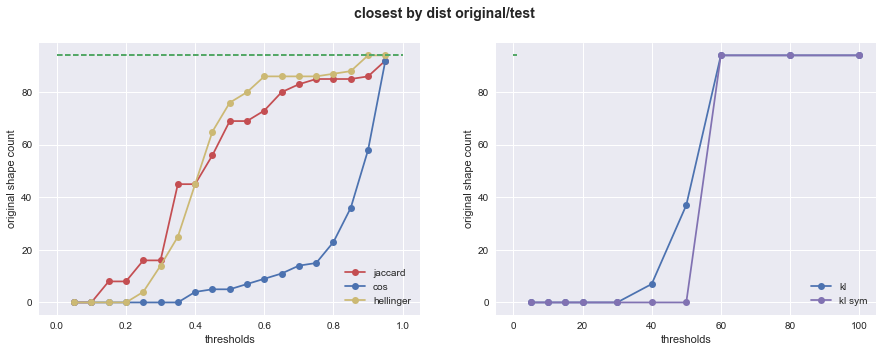

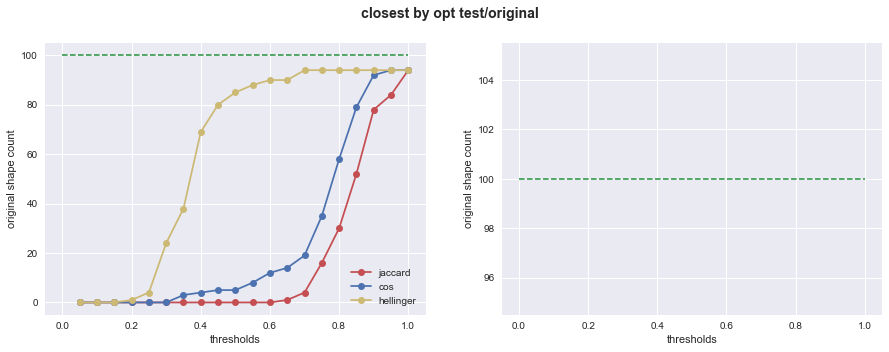

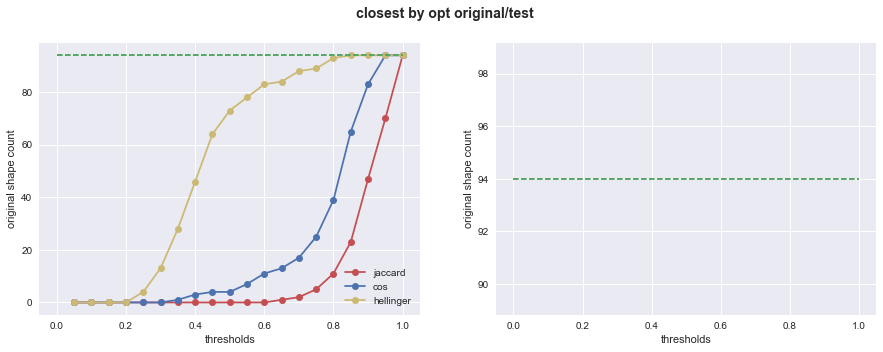

In [19]:
def create_model_rch_100_3_ts(n_iteration, model_name='', fit=True, n_topics=100):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=5, 
                                  _model_name=model_name)
    tmp_model.regularizers.add(artm.TopicSelectionThetaRegularizer(name='topic_selection_theta_regularizer'))    
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['topic_selection_theta_regularizer'].tau = 0.5
    tmp_model.regularizers['ss_theta_regularizer'].tau = -2
    tmp_model.regularizers['ss_phi_regularizer'].tau = -2
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 33
names_list[idx] = u'model_rch_100_3_ts'
models_list[idx] = create_model_rch_100_3_ts(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* 100 -> 94 (starting fit 25 it 96), 0.96
* **kernel size**: 24 vs 23, **purity**: .63 vs .55, **contrast** .78 vs .80, **$phi_{ij}$**: +++++ ok, but less close than prev
* **closest by dist**: 
* **inter distances**: 

|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|  closest by dist test/original   	|  j8 	|  jh44 |j72-h86| jh86 	|
|   closest by dist original/test  	|   -  	|   -  	|   - 	|  -  	|
| closest by opt res test/original 	|     	|  h70 	|  h90 	|  h96 	|
| closest by opt res original/test 	|     	|  h46 	|  h84 	| h100 	|
* **Выводы**: 
* **TODO**:

Увеличим коэффициент отбора тем от 0.5 до 0.7

name = model_rch_100_4_ts_iter_0, n_topics = 100, n_doc_passes = 5, seed_value = 100, n_iterations = 5, top_tokens_score = 15, topic_kernel_score = 0.25

name = model_rch_100_4_ts_iter_0, n_topics = 100, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -2
ss_phi_regularizer, tau = -2
topic_selection_theta_regularizer, tau = 0.7

('Filtered topics: ', 92, [u'topic_0', u'topic_1', u'topic_2', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_22', u'topic_23', u'topic_24', u'topic_25', u'topic_26', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_34', u'topic_35', u'topic_36', u'topic_37', u'topic_38', u'topic_40', u'topic_41', u'topic_42', u'topic_43', u'topic_44', u'topic_45', u'topic_46', u'topic_47', u'topic_48

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00    92.00
non zero ratio                    0.96     0.95
|phi_ij == 0| / n_topics       2126.43  2115.11
|phi_ij > 0.2| / n_topics         0.23     0.30
|phi_ij > 0.1| / n_topics         0.89     1.01
|phi_ij > 0.01| / n_topics       27.16    24.47
|phi_ij > 0.05| / n_topics        2.63     3.05
|phi_ij > 0.001| / n_topics      80.26    83.18
topic_kernel_average_size        23.68    22.65
topic_kernel_average_purity       0.63     0.53
topic_kernel_average_contrast     0.78     0.82

Dist fn = <function kl_sym_dist at 0x000000000C0CF438>, Processed th = 100, original columns count = 92        Processing <function jaccard_dist at 0x000000000C0CF4A8>
Processing <function cos_dist at 0x000000000C0CF588>
Processing <function hellinger_dist at 0x000000000C0CF5F8>
Processing <function kl_dist at 0x000000000C01A6D8>
Processing <function kl_sym_dist at 0x000000000C0CF438>
Processing <function jaccard_dist at 0x000000000C0CF4A8>
Processing <function cos_dist at 0x000000000C0CF588>
Processing <function hellinger_dist at 0x000000000C0CF5F8>
Processing <function kl_dist at 0x000000000C01A6D8>
Processing <function kl_sym_dist at 0x000000000C0CF438>
Dist fn = <function cos_dist at 0x000000000C0CF588>, Processed th = 1.0, original columns count = 92           Column topic_10 not optimized
Column topic_14 not optimized
Column topic_16 not optimized
Column topic_24 not optimized
Column topic_25 not optimized
Column topic_27 not optimized
Column topic_28 not optimized
Column topic_3

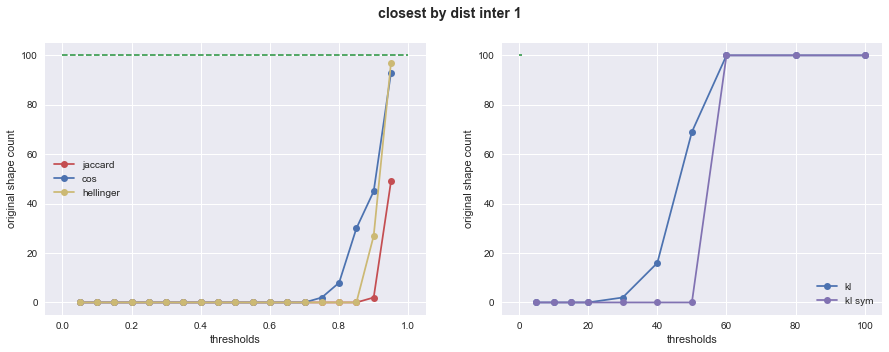

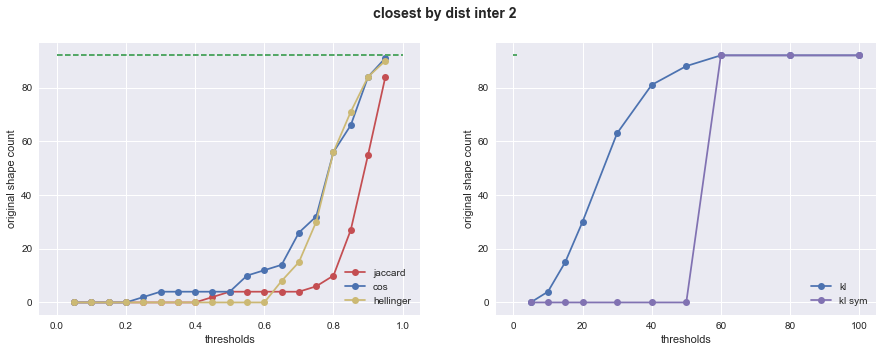

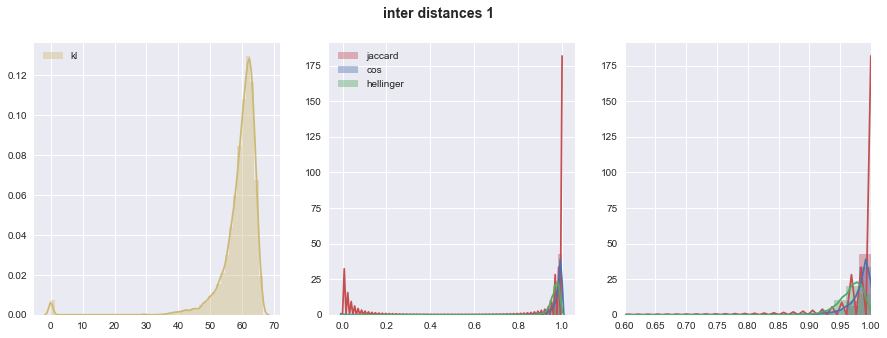

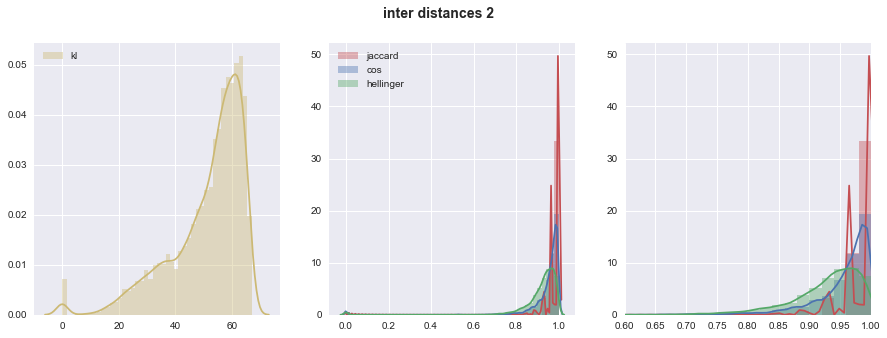

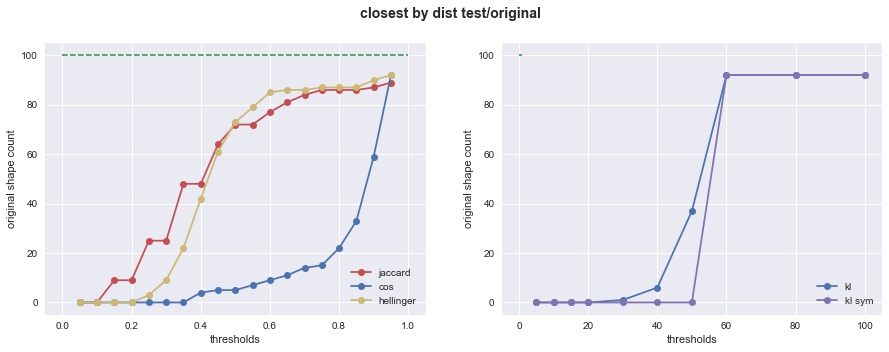

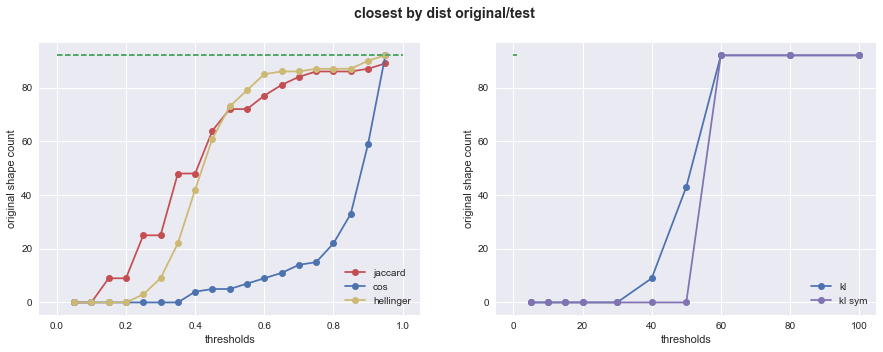

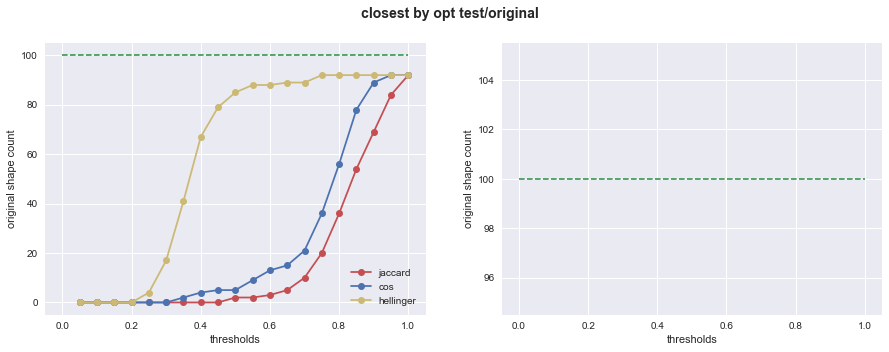

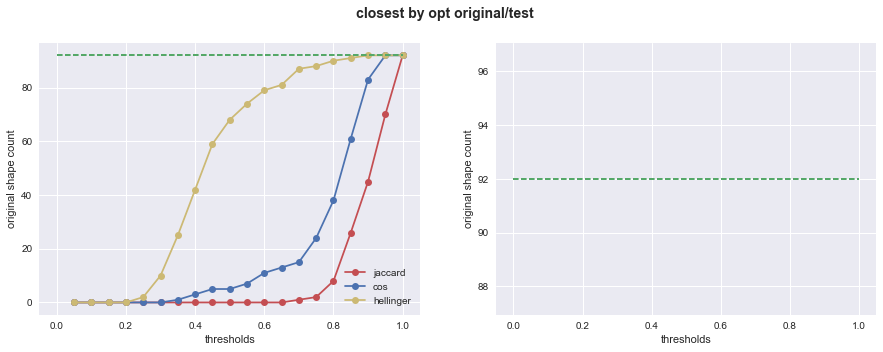

In [20]:
def create_model_rch_100_4_ts(n_iteration, model_name='', fit=True, n_topics=100):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=5, 
                                  _model_name=model_name)
    tmp_model.regularizers.add(artm.TopicSelectionThetaRegularizer(name='topic_selection_theta_regularizer'))    
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['topic_selection_theta_regularizer'].tau = 0.7
    tmp_model.regularizers['ss_theta_regularizer'].tau = -2
    tmp_model.regularizers['ss_phi_regularizer'].tau = -2
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 34
names_list[idx] = u'model_rch_100_4_ts'
models_list[idx] = create_model_rch_100_4_ts(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* 100 -> 92 (95 with 25 starting its), 0.92
* **kernel size**: 24 vs 23, **purity**: .63 vs .52, **contrast** .78 vs .81, **$phi_{ij}$**: +++++ soo close (with 25 starting its)
* **closest by dist**: 
* **inter distances**: 

|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|  closest by dist test/original   	|  j10 	|j48-h42|j78-h84| jh85 	|
|   closest by dist original/test  	|   -  	|   -  	|   - 	|  -  	|
| closest by opt res test/original 	|     	|  h68 	|  h90 	|  h92 	|
| closest by opt res original/test 	|     	|  h41 	|  h80 	|  h98 	|
* **Выводы**: 
* **TODO**:

Без регуляризаторов

name = model_rch_100_5_ts_iter_0, n_topics = 100, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25

('Filtered topics: ', 99, [u'topic_0', u'topic_1', u'topic_2', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_19', u'topic_20', u'topic_21', u'topic_22', u'topic_23', u'topic_24', u'topic_25', u'topic_26', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_34', u'topic_35', u'topic_36', u'topic_37', u'topic_38', u'topic_39', u'topic_40', u'topic_41', u'topic_42', u'topic_43', u'topic_44', u'topic_45', u'topic_46', u'topic_47', u'topic_49', u'topic_50', u'topic_51', u'topic_52', u'topic_53', u'topic_54', u'topic_55', u'topic_56', u'topic_57', u'topic_58', u'topic_59', u'topic_60', u'topic_61', u'topic_62', u'topic_63', u'topic_6

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00    99.00
non zero ratio                    0.96     0.83
|phi_ij == 0| / n_topics       2126.43  1841.47
|phi_ij > 0.2| / n_topics         0.23     0.66
|phi_ij > 0.1| / n_topics         0.89     1.55
|phi_ij > 0.01| / n_topics       27.16    20.07
|phi_ij > 0.05| / n_topics        2.63     3.96
|phi_ij > 0.001| / n_topics      80.26    57.04
topic_kernel_average_size        23.68    24.11
topic_kernel_average_purity       0.63     0.68
topic_kernel_average_contrast     0.78     0.79

Dist fn = <function kl_sym_dist at 0x000000000C0CF438>, Processed th = 100, original columns count = 99        Processing <function jaccard_dist at 0x000000000C0CF4A8>
Processing <function cos_dist at 0x000000000C0CF588>
Processing <function hellinger_dist at 0x000000000C0CF5F8>
Processing <function kl_dist at 0x000000000C01A6D8>
Processing <function kl_sym_dist at 0x000000000C0CF438>
Processing <function jaccard_dist at 0x000000000C0CF4A8>
Processing <function cos_dist at 0x000000000C0CF588>
Processing <function hellinger_dist at 0x000000000C0CF5F8>
Processing <function kl_dist at 0x000000000C01A6D8>
Processing <function kl_sym_dist at 0x000000000C0CF438>
Dist fn = <function cos_dist at 0x000000000C0CF588>, Processed th = 1.0, original columns count = 99           Column topic_88 not optimized
Dist fn = <function cos_dist at 0x000000000C0CF588>, Processed th = 1.0, original columns count = 99           Column topic_2 not optimized
Column topic_7 not optimized
Column topic_9 not optimi

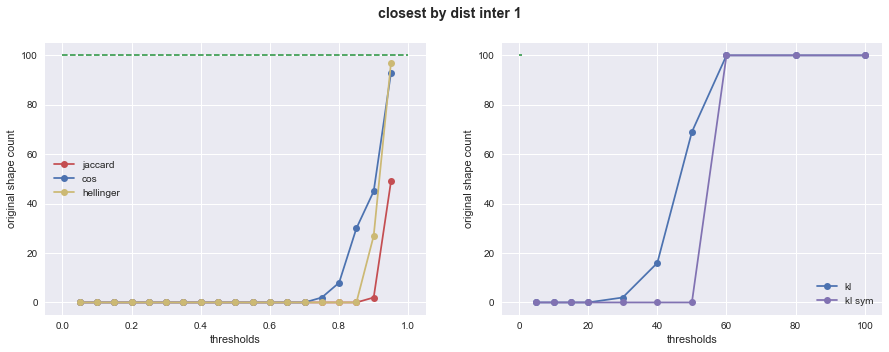

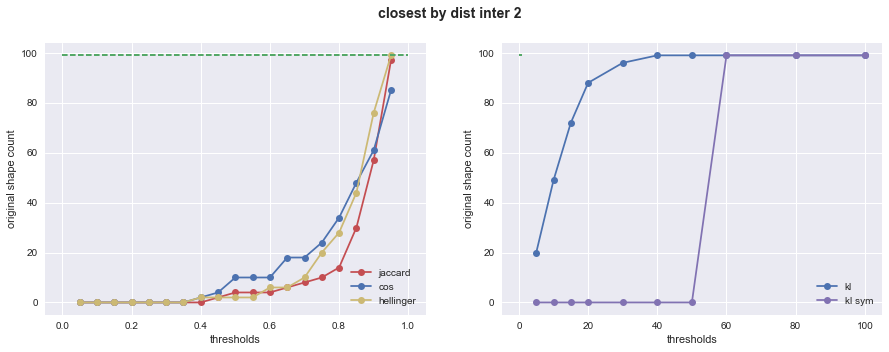

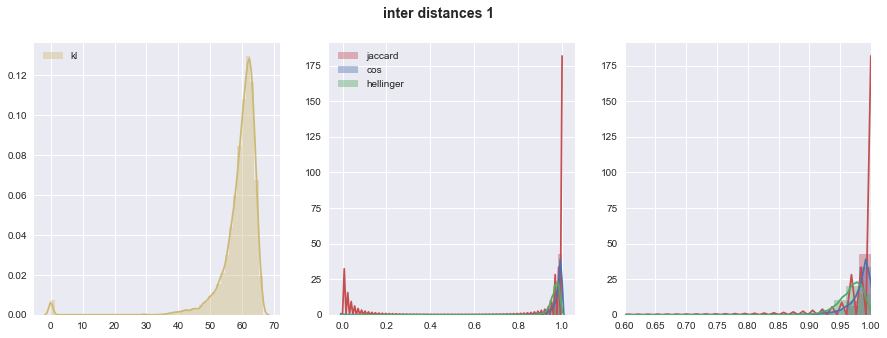

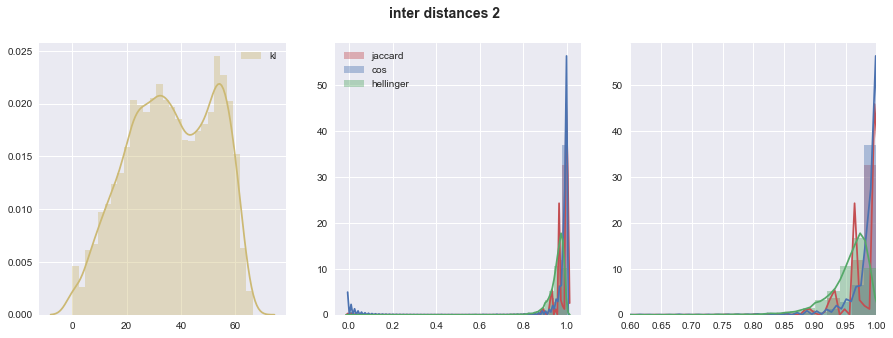

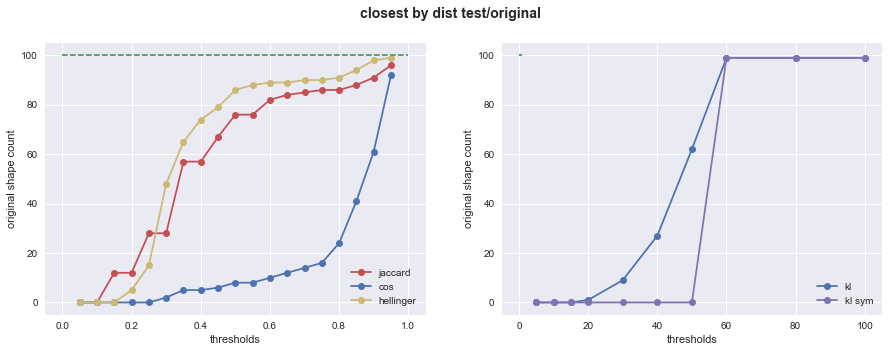

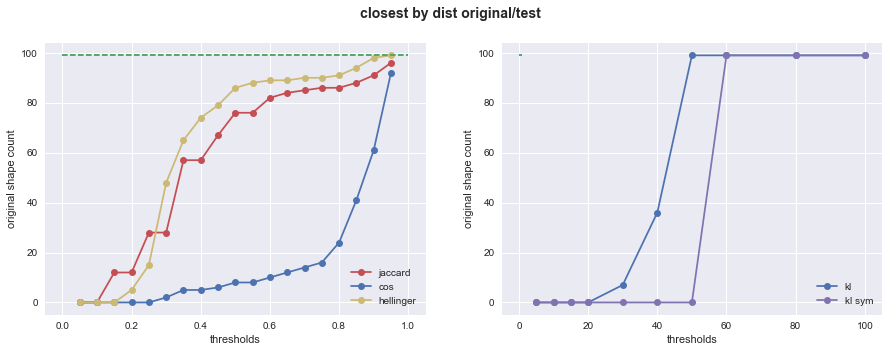

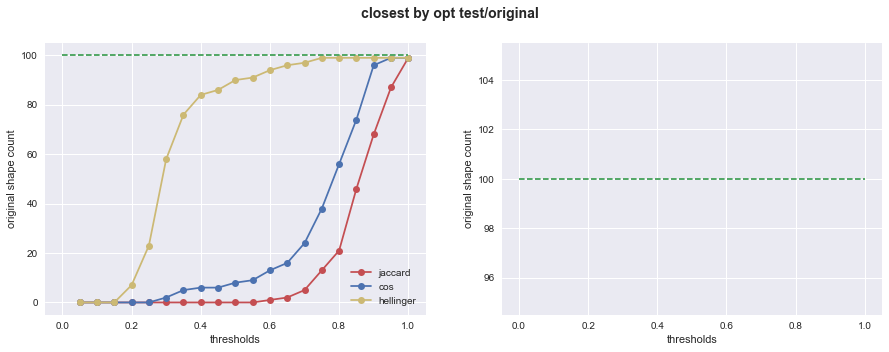

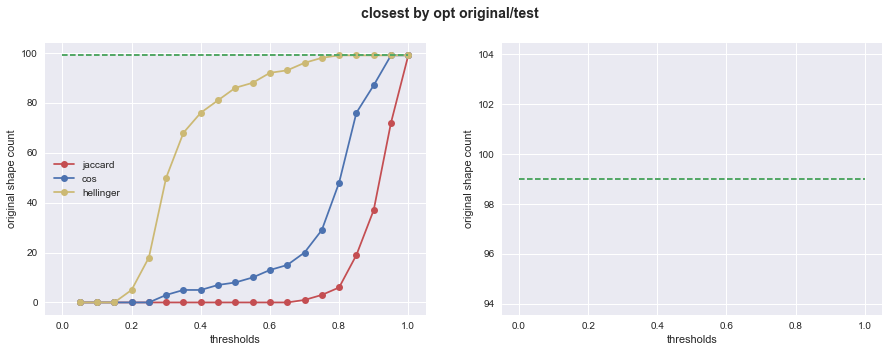

In [21]:
def create_model_rch_100_5_ts(n_iteration, model_name='', fit=True, n_topics=100):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)   
    return tmp_model

idx = 35
names_list[idx] = u'model_rch_100_5_ts'
models_list[idx] = create_model_rch_100_5_ts(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* 100 -> 99, 0.83
* **kernel size**: 24 vs 24, **purity**: .63 vs .68, **contrast** .78 vs .79, **$phi_{ij}$**: --+-+
* **closest by dist**: 
* **inter distances**: 

|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|  closest by dist test/original   	|  j12 	|j48-h76|j82-h90|j84-h92|
|   closest by dist original/test  	|   -  	|   -  	|   - 	|  -  	|
| closest by opt res test/original 	|  h8  	|  h84 	|  h94 	| h100	|
| closest by opt res original/test 	|     	|  h78 	|  h92 	| h100 	|
* **Выводы**: 
* **TODO**:

## decorrelator + topic selection

name = create_model_rch_100_1_decor_ts_iter_0, n_topics = 100, n_doc_passes = 5, seed_value = 100, n_iterations = 5, top_tokens_score = 15, topic_kernel_score = 0.25

name = create_model_rch_100_1_decor_ts_iter_0, n_topics = 100, n_doc_passes = 5, seed_value = 100, n_iterations = 15, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -2
decorrelator_phi_regularizer, tau = 6
ss_phi_regularizer, tau = -2

name = create_model_rch_100_1_decor_ts_iter_0, n_topics = 100, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -0.5
topic_selection_theta_regularizer, tau = 0.7
decorrelator_phi_regularizer, tau = 0
ss_phi_regularizer, tau = -0.5

('Filtered topics: ', 98, [u'topic_0', u'topic_1', u'topic_2', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00    98.00
non zero ratio                    0.96     0.98
|phi_ij == 0| / n_topics       2126.43  2162.21
|phi_ij > 0.2| / n_topics         0.23     0.57
|phi_ij > 0.1| / n_topics         0.89     1.57
|phi_ij > 0.01| / n_topics       27.16    21.80
|phi_ij > 0.05| / n_topics        2.63     4.13
|phi_ij > 0.001| / n_topics      80.26    50.73
topic_kernel_average_size        23.68    22.26
topic_kernel_average_purity       0.63     0.68
topic_kernel_average_contrast     0.78     0.82

Dist fn = <function kl_sym_dist at 0x000000000C0CF438>, Processed th = 100, original columns count = 98        Processing <function jaccard_dist at 0x000000000C0CF4A8>
Processing <function cos_dist at 0x000000000C0CF588>
Processing <function hellinger_dist at 0x000000000C0CF5F8>
Processing <function kl_dist at 0x000000000C01A6D8>
Processing <function kl_sym_dist at 0x000000000C0CF438>
Processing <function jaccard_dist at 0x000000000C0CF4A8>
Processing <function cos_dist at 0x000000000C0CF588>
Processing <function hellinger_dist at 0x000000000C0CF5F8>
Processing <function kl_dist at 0x000000000C01A6D8>
Processing <function kl_sym_dist at 0x000000000C0CF438>
Dist fn = <function cos_dist at 0x000000000C0CF588>, Processed th = 1.0, original columns count = 98           Column topic_1 not optimized
Column topic_3 not optimized
Column topic_12 not optimized
Column topic_25 not optimized
Column topic_31 not optimized
Column topic_36 not optimized
Column topic_40 not optimized
Column topic_41 

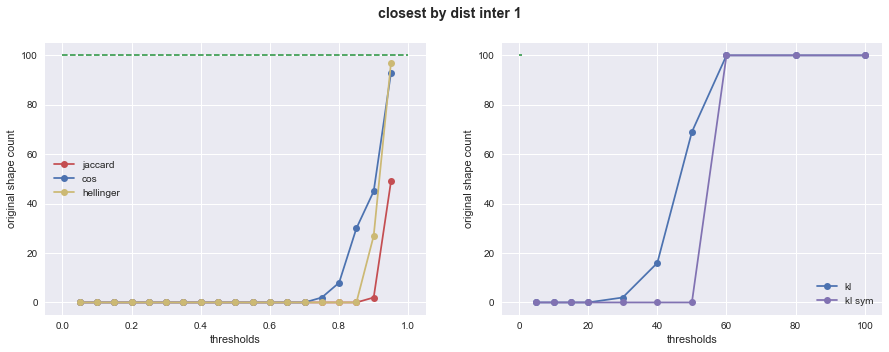

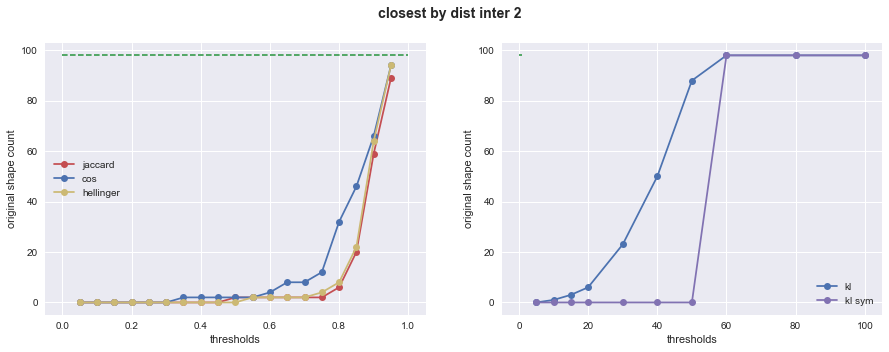

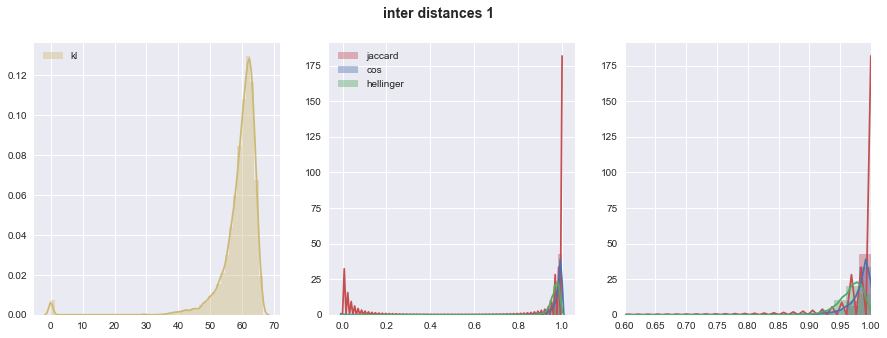

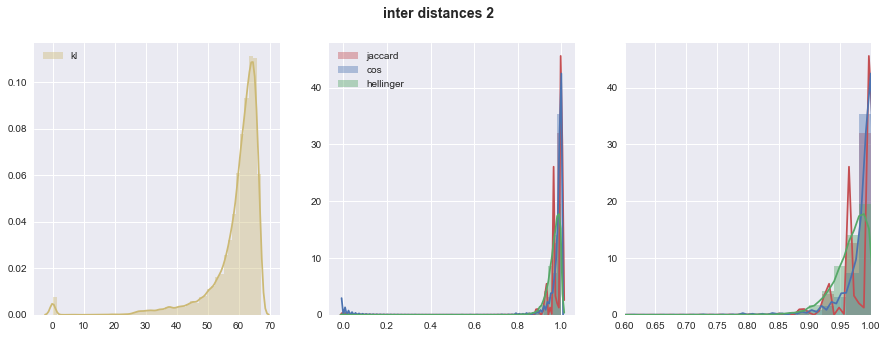

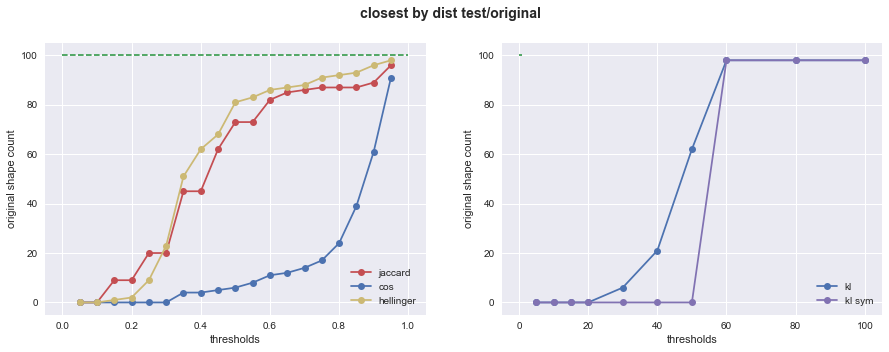

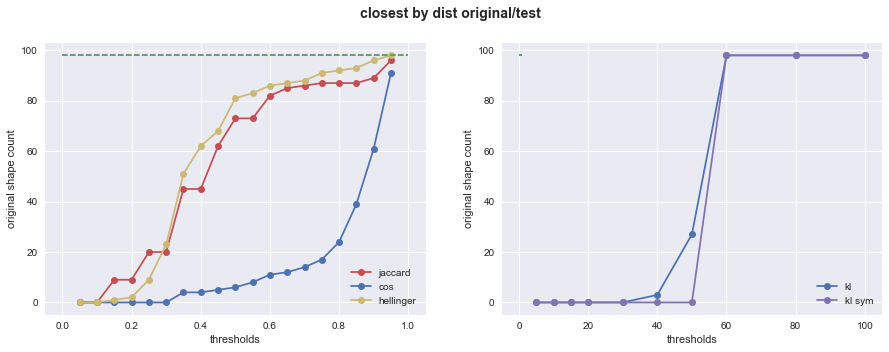

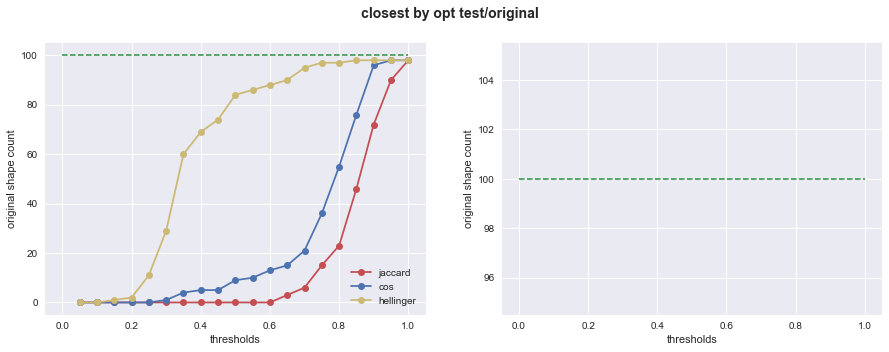

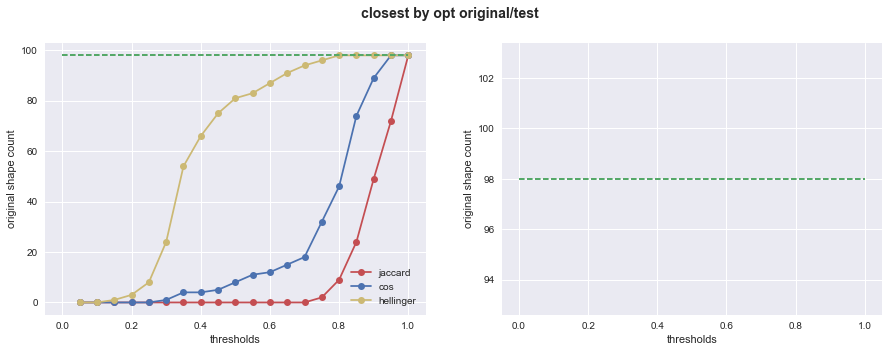

In [23]:
def create_model_rch_100_1_decor_ts(n_iteration, model_name='', fit=True, n_topics=100):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=5, 
                                  _model_name=model_name)
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 6
    tmp_model.regularizers['ss_theta_regularizer'].tau = -2
    tmp_model.regularizers['ss_phi_regularizer'].tau = -2    
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=15, 
                                  _model_name=model_name)
    
    tmp_model.regularizers.add(artm.TopicSelectionThetaRegularizer(name='topic_selection_theta_regularizer'))    
    tmp_model.regularizers['topic_selection_theta_regularizer'].tau = 0.7
    tmp_model.regularizers['ss_theta_regularizer'].tau = -0.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -0.5
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 0
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 41
names_list[idx] = u'create_model_rch_100_1_decor_ts'
models_list[idx] = create_model_rch_100_1_decor_ts(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* 100 -> 98, 0.98
* **kernel size**: 24 vs 23, **purity**: .63 vs .66, **contrast** .78 vs .81, **$phi_{ij}$**: --+-+
* **closest by dist**: 
* **inter distances**: 

|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|  closest by dist test/original   	|  j10 	|j44-h61|j81-h84|j86-h92|
|   closest by dist original/test  	|   -  	|   -  	|   - 	|  -  	|
| closest by opt res test/original 	|  h2  	|  h70 	|  h88 	| h98	|
| closest by opt res original/test 	|     	|  h64 	|  h88 	| h100 	|
* **Выводы**: 0.4 неплохо
* **TODO**:

Спарсе по -1,5 для сравнения с без топик селектиона

name = create_model_rch_100_2_decor_ts_iter_0, n_topics = 100, n_doc_passes = 5, seed_value = 100, n_iterations = 5, top_tokens_score = 15, topic_kernel_score = 0.25

name = create_model_rch_100_2_decor_ts_iter_0, n_topics = 100, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -2
decorrelator_phi_regularizer, tau = 6
ss_phi_regularizer, tau = -2

name = create_model_rch_100_2_decor_ts_iter_0, n_topics = 100, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -0.5
topic_selection_theta_regularizer, tau = 0.7
decorrelator_phi_regularizer, tau = 0
ss_phi_regularizer, tau = -0.5

('Filtered topics: ', 97, [u'topic_0', u'topic_1', u'topic_2', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00    97.00
non zero ratio                    0.96     0.98
|phi_ij == 0| / n_topics       2126.43  2162.62
|phi_ij > 0.2| / n_topics         0.23     0.56
|phi_ij > 0.1| / n_topics         0.89     1.55
|phi_ij > 0.01| / n_topics       27.16    21.85
|phi_ij > 0.05| / n_topics        2.63     4.13
|phi_ij > 0.001| / n_topics      80.26    50.51
topic_kernel_average_size        23.68    22.44
topic_kernel_average_purity       0.63     0.68
topic_kernel_average_contrast     0.78     0.82

Dist fn = <function kl_sym_dist at 0x000000000C0CF438>, Processed th = 100, original columns count = 97        Processing <function jaccard_dist at 0x000000000C0CF4A8>
Processing <function cos_dist at 0x000000000C0CF588>
Processing <function hellinger_dist at 0x000000000C0CF5F8>
Processing <function kl_dist at 0x000000000C01A6D8>
Processing <function kl_sym_dist at 0x000000000C0CF438>
Processing <function jaccard_dist at 0x000000000C0CF4A8>
Processing <function cos_dist at 0x000000000C0CF588>
Processing <function hellinger_dist at 0x000000000C0CF5F8>
Processing <function kl_dist at 0x000000000C01A6D8>
Processing <function kl_sym_dist at 0x000000000C0CF438>
Dist fn = <function cos_dist at 0x000000000C0CF588>, Processed th = 1.0, original columns count = 97           Column topic_63 not optimized
Column topic_83 not optimized
Dist fn = <function cos_dist at 0x000000000C0CF588>, Processed th = 1.0, original columns count = 97           Column topic_1 not optimized
Column topic_9 not optim

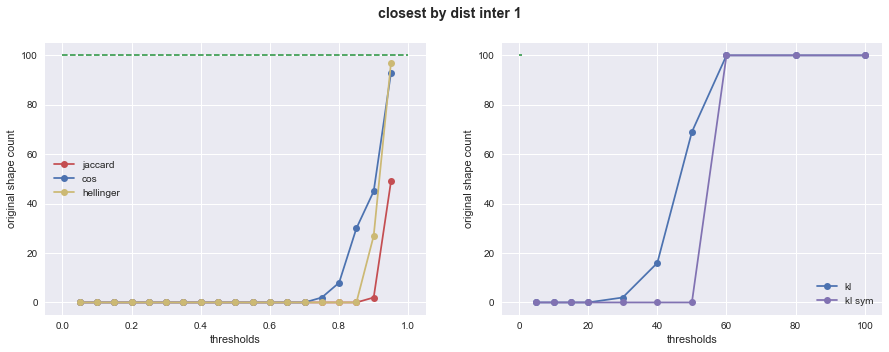

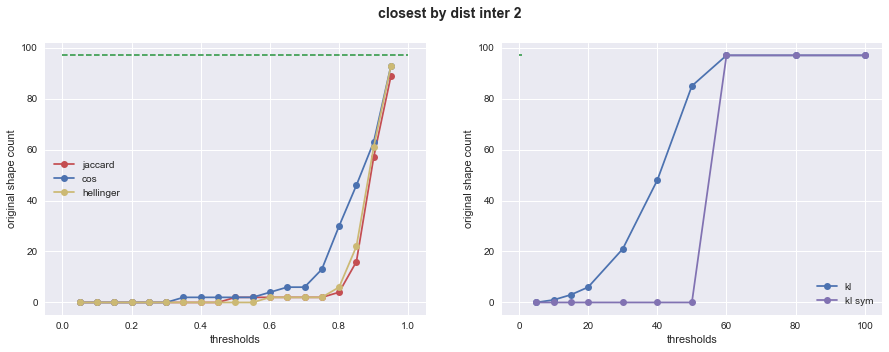

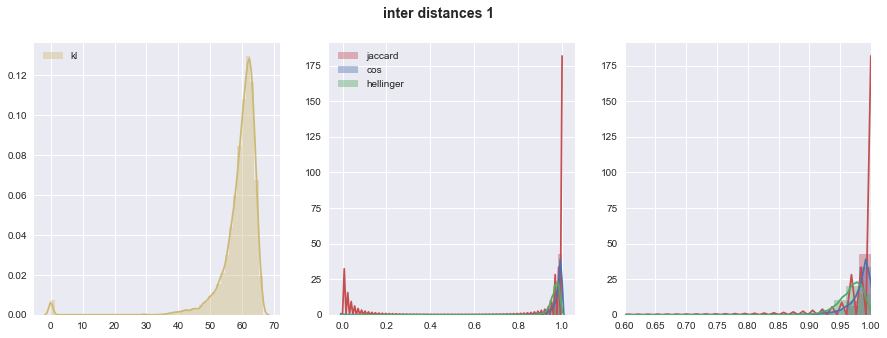

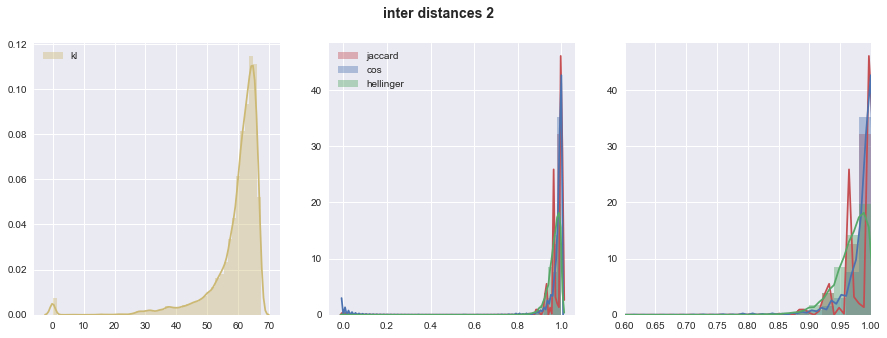

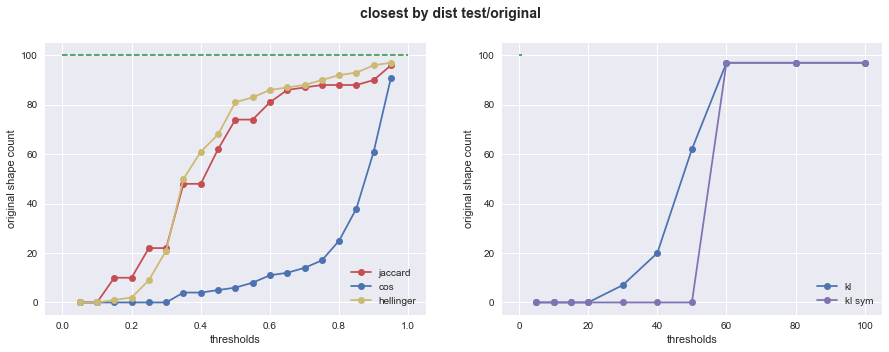

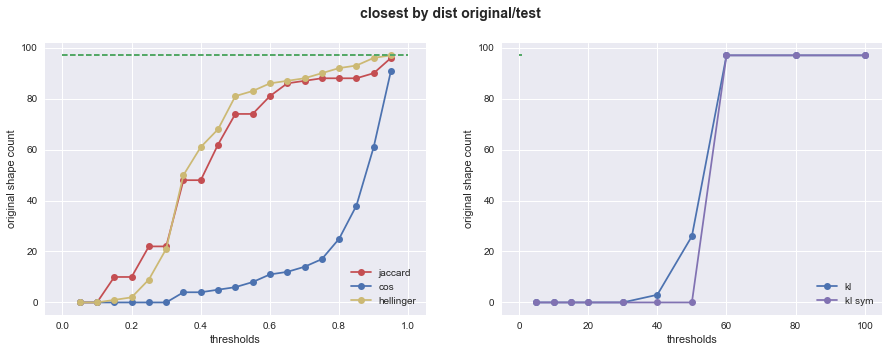

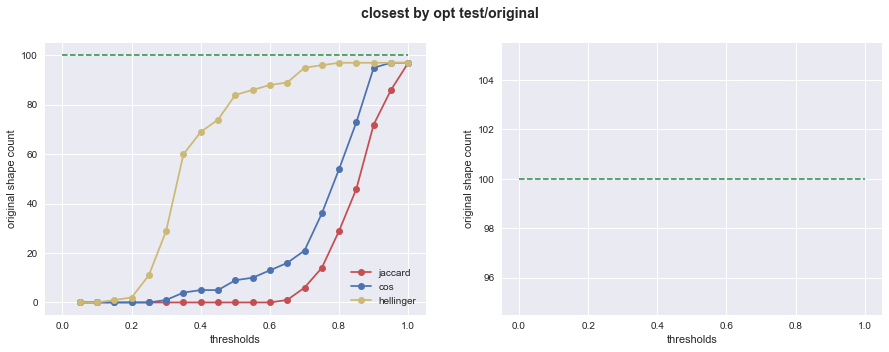

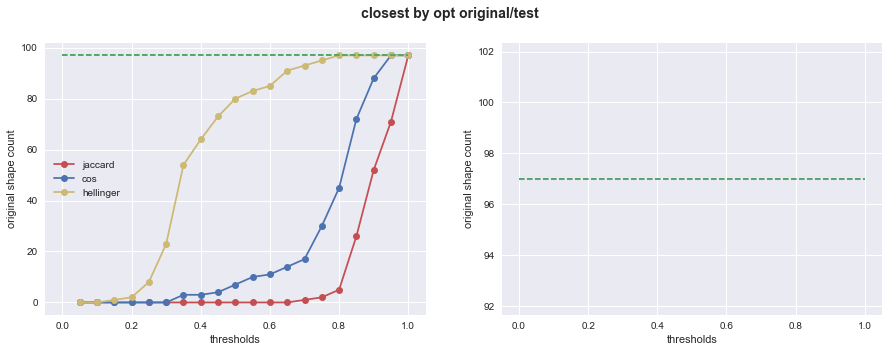

In [22]:
def create_model_rch_100_2_decor_ts(n_iteration, model_name='', fit=True, n_topics=100):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=5, 
                                  _model_name=model_name)
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 6
    tmp_model.regularizers['ss_theta_regularizer'].tau = -2
    tmp_model.regularizers['ss_phi_regularizer'].tau = -2    
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    
    tmp_model.regularizers.add(artm.TopicSelectionThetaRegularizer(name='topic_selection_theta_regularizer'))    
    tmp_model.regularizers['topic_selection_theta_regularizer'].tau = 0.7
    tmp_model.regularizers['ss_theta_regularizer'].tau = -0.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -0.5
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 0
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 42
names_list[idx] = u'create_model_rch_100_2_decor_ts'
models_list[idx] = create_model_rch_100_2_decor_ts(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* 100 -> 97, 0.98
* **kernel size**: 24 vs 22, **purity**: .63 vs .68, **contrast** .78 vs .82, **$phi_{ij}$**: --+--
* **closest by dist**: 
* **inter distances**: 

|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|  closest by dist test/original   	|  j10 	|j48-h60|j81-h84|j84-h92|
|   closest by dist original/test  	|   -  	|   -  	|   - 	|  -  	|
| closest by opt res test/original 	|  h8  	|  h70 	|  h88 	| h98	|

| closest by opt res original/test 	|     	|  h64 	|  h84 	| h100 	|

увеличим топик селекьтон коэф


name = create_model_rch_100_3_decor_ts_iter_0, n_topics = 100, n_doc_passes = 5, seed_value = 100, n_iterations = 5, top_tokens_score = 15, topic_kernel_score = 0.25

name = create_model_rch_100_3_decor_ts_iter_0, n_topics = 100, n_doc_passes = 5, seed_value = 100, n_iterations = 15, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -1.5
decorrelator_phi_regularizer, tau = 6
ss_phi_regularizer, tau = -1.5

name = create_model_rch_100_3_decor_ts_iter_0, n_topics = 100, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -0.5
topic_selection_theta_regularizer, tau = 0.9
decorrelator_phi_regularizer, tau = 0
ss_phi_regularizer, tau = -0.5

('Filtered topics: ', 98, [u'topic_0', u'topic_1', u'topic_2', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00    98.00
non zero ratio                    0.96     0.97
|phi_ij == 0| / n_topics       2126.43  2160.13
|phi_ij > 0.2| / n_topics         0.23     0.56
|phi_ij > 0.1| / n_topics         0.89     1.52
|phi_ij > 0.01| / n_topics       27.16    21.93
|phi_ij > 0.05| / n_topics        2.63     4.10
|phi_ij > 0.001| / n_topics      80.26    51.96
topic_kernel_average_size        23.68    22.73
topic_kernel_average_purity       0.63     0.67
topic_kernel_average_contrast     0.78     0.82

Dist fn = <function kl_sym_dist at 0x000000000C0CF438>, Processed th = 100, original columns count = 98        Processing <function jaccard_dist at 0x000000000C0CF4A8>
Processing <function cos_dist at 0x000000000C0CF588>
Processing <function hellinger_dist at 0x000000000C0CF5F8>
Processing <function kl_dist at 0x000000000C01A6D8>
Processing <function kl_sym_dist at 0x000000000C0CF438>
Processing <function jaccard_dist at 0x000000000C0CF4A8>
Processing <function cos_dist at 0x000000000C0CF588>
Processing <function hellinger_dist at 0x000000000C0CF5F8>
Processing <function kl_dist at 0x000000000C01A6D8>
Processing <function kl_sym_dist at 0x000000000C0CF438>
Dist fn = <function cos_dist at 0x000000000C0CF588>, Processed th = 1.0, original columns count = 98           Column topic_33 not optimized
Column topic_46 not optimized
Column topic_47 not optimized
Column topic_50 not optimized
Column topic_51 not optimized
Column topic_52 not optimized
Column topic_54 not optimized
Column topic_7

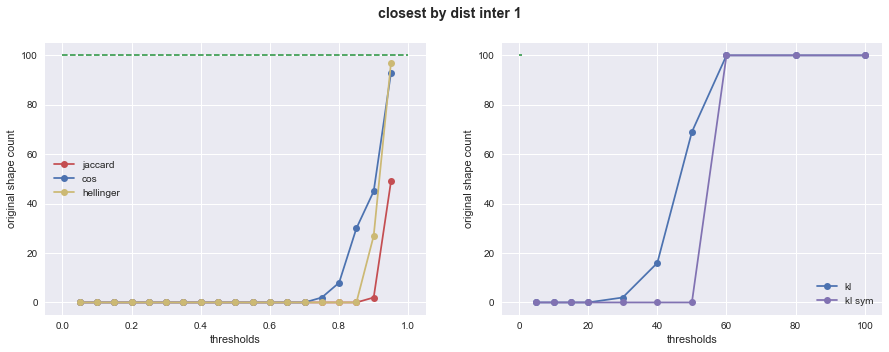

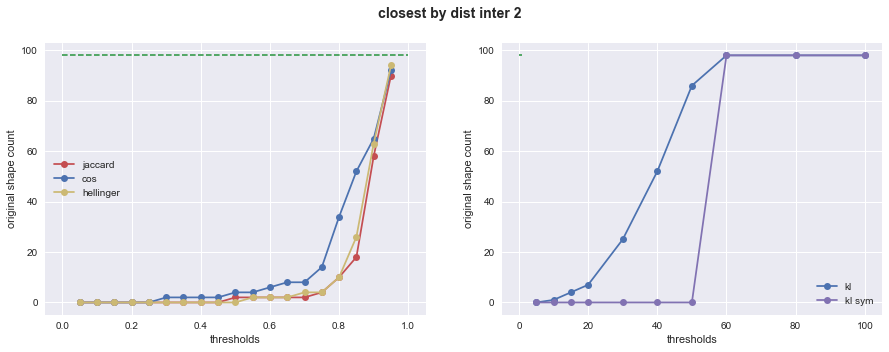

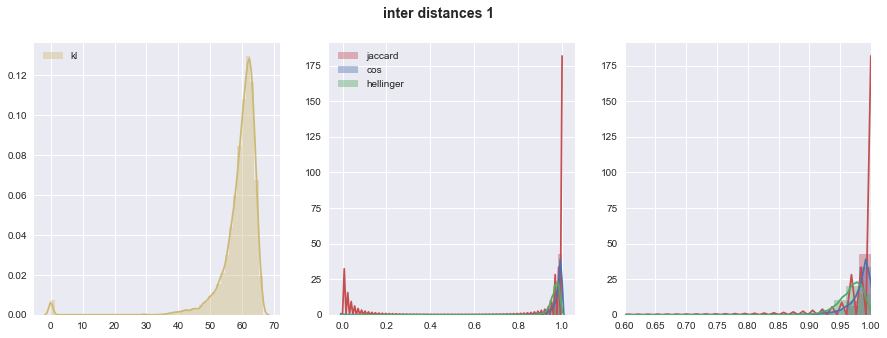

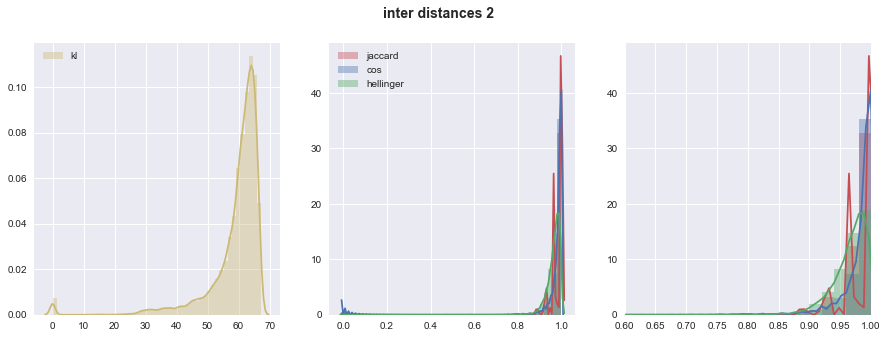

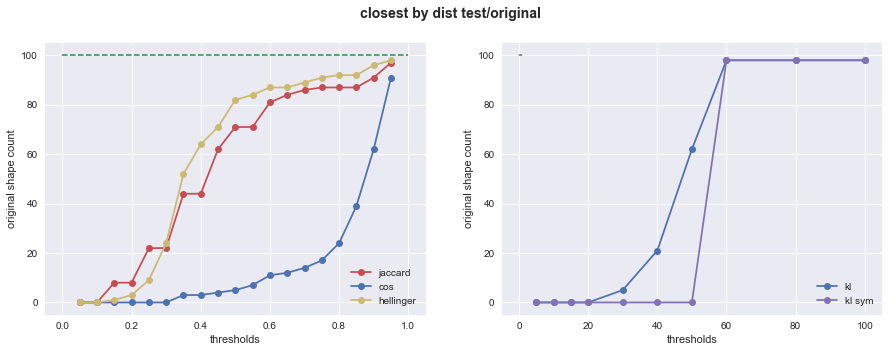

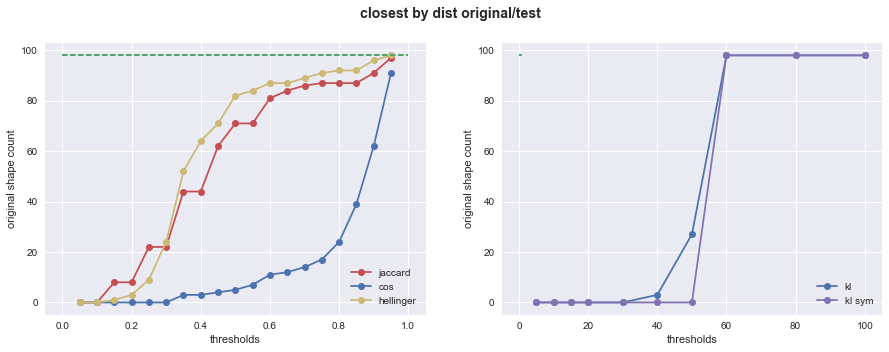

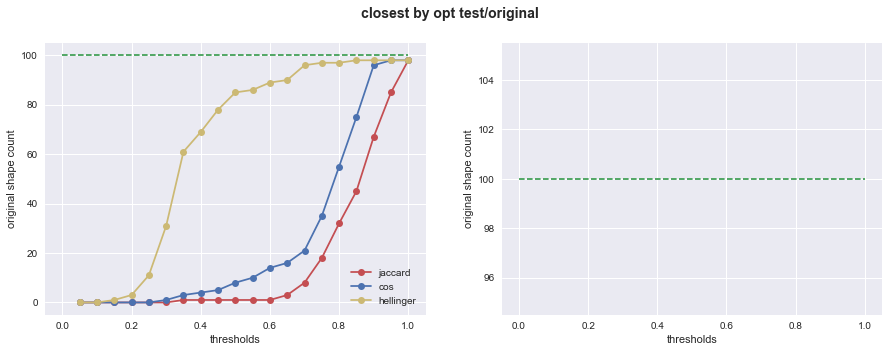

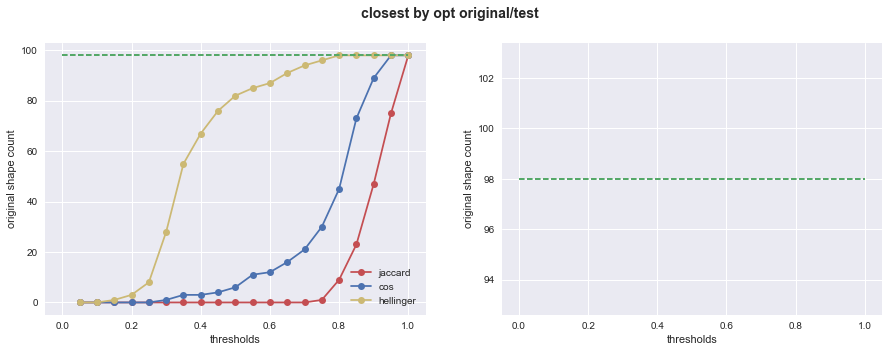

In [25]:
def create_model_rch_100_3_decor_ts(n_iteration, model_name='', fit=True, n_topics=100):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=5, 
                                  _model_name=model_name)
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 6
    tmp_model.regularizers['ss_theta_regularizer'].tau = -1.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -1.5    
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=15, 
                                  _model_name=model_name)
    
    tmp_model.regularizers.add(artm.TopicSelectionThetaRegularizer(name='topic_selection_theta_regularizer'))    
    tmp_model.regularizers['topic_selection_theta_regularizer'].tau = 0.9
    tmp_model.regularizers['ss_theta_regularizer'].tau = -0.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -0.5
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 0
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 41
names_list[idx] = u'create_model_rch_100_3_decor_ts'
models_list[idx] = create_model_rch_100_3_decor_ts(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* 100 -> 98, 0.97
* **kernel size**: 24 vs 23, **purity**: .63 vs .67, **contrast** .78 vs .82, **$phi_{ij}$**: --+-+
* **closest by dist**: 
* **inter distances**: 

|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|  closest by dist test/original   	|  j10 	|j42-h64|j81-h86|j84-h92|
|   closest by dist original/test  	|   -  	|   -  	|   - 	|  -  	|
| closest by opt res test/original 	|    	|  h70 	|  h90 	| h98	|
| closest by opt res original/test 	|     	|  h64 	|  h90 	| h100 	|
* **Выводы**: 
* **TODO**:

## old 

[2017-02-26 23:24:34.002000] ********** iteration = 1 / 150
name = model_20_reg_3_iter_0, n_topics = 20, n_doc_passes = 5, seed_value = 100, n_iterations = 20, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -10
ss_phi_regularizer, tau = -10

[2017-02-26 23:24:42.912000] filtering iteration = 1 / 50
[2017-02-26 23:24:45.105000] 0 topics to remove, 0 not_removed_topics_count because close topics, current convex_hull shape = (2216, 20)
[2017-02-26 23:24:45.105000] topics to remove not increasing, breaking the for loop
[2017-02-26 23:24:45.105000] current convex_hull shape = (2216, 20)
[2017-02-26 23:24:45.105000] ********** iteration = 2 / 150
name = model_20_reg_3_iter_1, n_topics = 20, n_doc_passes = 5, seed_value = 101, n_iterations = 20, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -10
ss_phi_regularizer, tau = -10

[2017-02-26 23:24:54.846000] filtering iteration = 1 / 50
[2017-02-26 23:25:00.048000] 3 topics to remove, 26

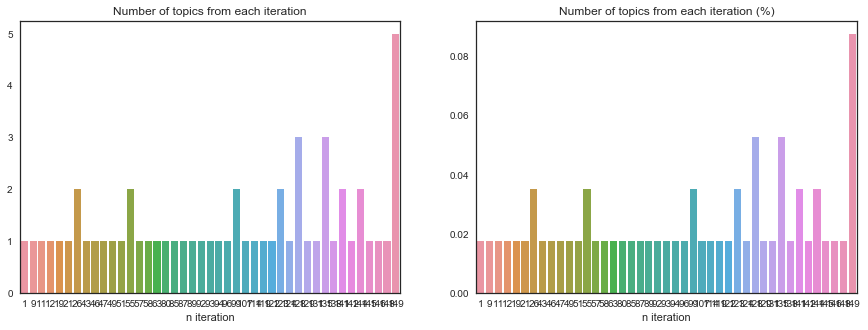

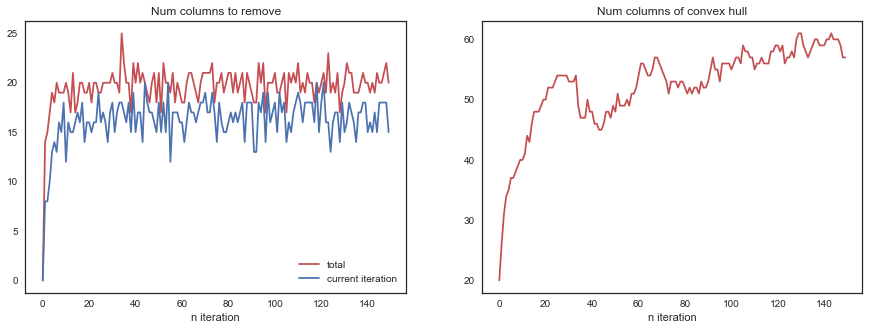

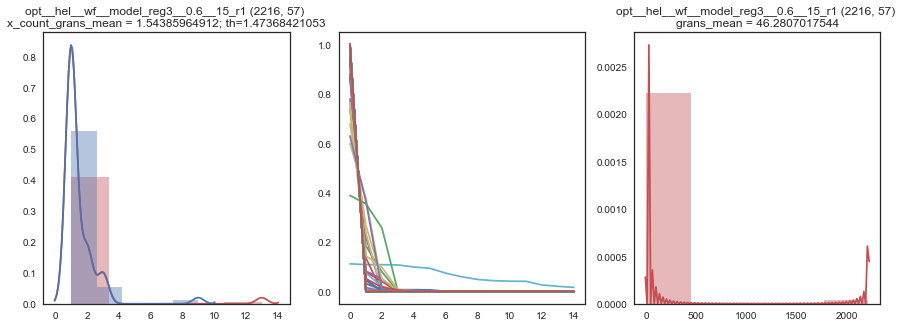

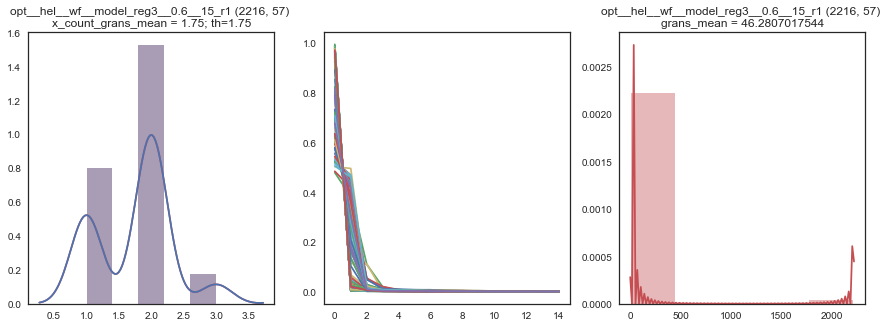

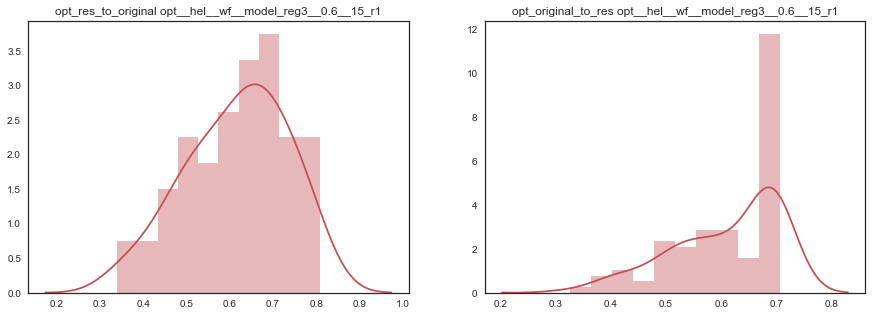

In [12]:
%matplotlib inline
idx = 0

OPT_FUN_THRESHOLD, N_CLOSEST_TOPICS_COUNT, DIST_FN = 0.6, 15, dh.hellinger_dist
names_list[idx] = 'opt__jac__wf__model_rch1__0.6__15_r1'
phi_convex_hull_list[idx], iterations_info_list[idx], iterations_filtering_list[idx] = bchh \
                                                    .build_convex_hull_with_filtering(
                                                     [],
                                                     create_model_rch1,
                                                     bchh.get_topics_to_remove_by_opt_fun_and_distance, 
                                                     DIST_FN,
                                                     bchh.get_optimization_result_one_matrix,
                                                     phi_original.index,
                                                     init_convex_hull=[], start_iteration=0,
                                                     n_closest_topics_count=N_CLOSEST_TOPICS_COUNT,
                                                     opt_fun_threshold=OPT_FUN_THRESHOLD,
                                                     max_iteration=5,
                                                     use_previous_iterations=False)

distances_to_original_list[idx], opt_res_to_original_list[idx], opt_original_to_res_list[idx], different_distances, different_distances_to_original = save_and_plot(idx, 
            names_list, phi_convex_hull_list, iterations_info_list, iterations_filtering_list)